# Executive Summary

Goals: Build a new regression model to predict logerror (log(Zestimate) - log(SalePrice)), and use clustering to see if we can find groups of similar observations to generate new features to be fed into our supervised model.

Best Features: 

Takeaways: N/A

In [1]:
#imports
import os
import pandas as pd
from env import username, host, password 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from wrangle import get_zillow_data, prepare_zillow, train_validate_test_split, train_validate_test, impute_nulls, split_X_y, standard_scale_data, get_object_cols, get_numeric_X_cols, nulls_by_col, nulls_by_row  
from explore import explore_univariate, create_cluster, create_scatter_plot, get_zillow_heatmap

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score

# Acquire Stage 

In [2]:
#acquire our Zillow data from CodeUp server by parcel id specifically those that are single unit property values.
df = get_zillow_data()

In [3]:
df.shape

(77575, 68)

In [4]:
df

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,1727539,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1387261,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,11677,NaN,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,2288172,NaN,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,NaN,NaN,266.0,2.0,NaN,NaN,1.0,10887214,1970746,NaN,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77570,NaN,NaN,266.0,2.0,NaN,NaN,1.0,10833991,2864704,NaN,...,6.037132e+13,-0.002245,2017-09-20,Central,NaN,NaN,Central,Condominium,NaN,NaN
77571,NaN,NaN,261.0,2.0,NaN,NaN,NaN,11000655,673515,NaN,...,6.037101e+13,0.020615,2017-09-20,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77572,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17239384,2968375,NaN,...,6.111008e+13,0.013209,2017-09-21,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
77573,NaN,NaN,261.0,2.0,NaN,NaN,1.0,12773139,1843709,NaN,...,6.037434e+13,0.037129,2017-09-21,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [5]:
df.isnull().sum()[df.isnull().sum()>0]

typeconstructiontypeid          77353
storytypeid                     77525
heatingorsystemtypeid           28005
buildingclasstypeid             77560
architecturalstyletypeid        77369
airconditioningtypeid           52569
basementsqft                    77525
buildingqualitytypeid           27766
calculatedbathnbr                 615
decktypeid                      76961
finishedfloor1squarefeet        71540
calculatedfinishedsquarefeet      200
finishedsquarefeet12             3655
finishedsquarefeet13            77533
finishedsquarefeet15            74548
finishedsquarefeet50            71540
finishedsquarefeet6             77189
fireplacecnt                    69288
fullbathcnt                       615
garagecarcnt                    52058
garagetotalsqft                 52058
hashottuborspa                  76036
lotsizesquarefeet                8257
poolcnt                         61402
poolsizesum                     76706
pooltypeid10                    77110
pooltypeid2 

In [6]:
nulls_by_col(df)

<class 'pandas.core.series.Series'>


,num_rows_missing,percent_rows_missing
typeconstructiontypeid,77353,99.713825
storytypeid,77525,99.935546
propertylandusetypeid,0,0.000000
heatingorsystemtypeid,28005,36.100548
buildingclasstypeid,77560,99.980664
...,...,...
buildingclassdesc,77560,99.980664
heatingorsystemdesc,28005,36.100548
propertylandusedesc,0,0.000000
storydesc,77525,99.935546


In [7]:
nulls_by_row(df)

,num_cols_missing,percent_cols_missing,num_rows
0,23,33.82352941176471,2
1,24,35.294117647058826,13
2,25,36.76470588235294,24
3,26,38.23529411764706,65
4,27,39.705882352941174,316
5,28,41.17647058823529,457
6,29,42.64705882352941,5285
7,30,44.11764705882353,3465
8,31,45.588235294117645,9911
9,32,47.05882352941176,12606


In [8]:
df = prepare_zillow(df)

In [9]:
df.shape

(50195, 42)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50195 entries, 0 to 77574
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   propertylandusetypeid       50195 non-null  float64
 1   parcel_id                   50195 non-null  int64  
 2   id                          50195 non-null  int64  
 3   baths                       50195 non-null  float64
 4   beds                        50195 non-null  float64
 5   calculatedbathnbr           50117 non-null  float64
 6   sqft                        50195 non-null  float64
 7   finishedsquarefeet12        49990 non-null  float64
 8   fullbathcnt                 50117 non-null  float64
 9   latitude                    50195 non-null  float64
 10  longitude                   50195 non-null  float64
 11  lotsizesquarefeet           49892 non-null  float64
 12  propertycountylandusecode   50195 non-null  object 
 13  rawcensustractandblock      501

In [11]:
#split into train, validate, test. Our target is logerror
train, validate, test = train_validate_test_split(df, 'logerror', seed=1349)

In [12]:
#return our train, validate, and test sets with calculatedbathnbr, fullbathcnt, regionidcity, regionidzip,censustractandblock
#imputed with most frequent values
train, validate, test = impute_nulls(train, validate, test, strategy='most_frequent', 
                        col_list=['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'censustractandblock'])

In [13]:
#return our train, validate, and test sets with finishedsquarefeet12, lotsizesquarefeet, structuretaxvaluedollarcnt, 
#tax_value, land tax value dollar count, and tax amount imputed with the column's median value. 
train, validate, test = impute_nulls(train, validate, test, strategy='median', 
                        col_list=['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 
                                  'tax_value', 'landtaxvaluedollarcnt', 'tax_amount'])

In [14]:
#drop rows with remaining nulls from all of our split sets
train = train.dropna()
validate = validate.dropna()
test = test.dropna()

In [15]:

#assuring there are no more nulls and we can almost get to work
train.isna().sum().sum() + validate.isna().sum().sum() + test.isna().sum().sum()

0

In [16]:
#split new train, validate, and test into X_train, y_train, X_validate, y_validate, X_test, y_test with logerror as our target
X_train, y_train, X_validate, y_validate, X_test, y_test = split_X_y(train, validate, test, 'logerror')

In [17]:
#get object columns, and numeric columns so we can scale our data
obj_cols = get_object_cols(X_train)
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [18]:
obj_cols

['propertycountylandusecode',
 'transactiondate',
 'propertylandusedesc',
 'county']

In [19]:
num_cols

['propertylandusetypeid',
 'parcel_id',
 'id',
 'baths',
 'beds',
 'calculatedbathnbr',
 'sqft',
 'finishedsquarefeet12',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'rawcensustractandblock',
 'regionidcity',
 'regionidzip',
 'roomcnt',
 'year_built',
 'structuretaxvaluedollarcnt',
 'tax_value',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'tax_amount',
 'censustractandblock',
 'LA',
 'Orange',
 'Ventura',
 'age',
 'age_bin',
 'taxrate',
 'acres',
 'acres_bin',
 'sqft_bin',
 'structure_dollar_per_sqft',
 'cola',
 'los_angeles',
 'orange',
 'ventura']

In [20]:
#scale our X_train, X_validate, and X_test with standard scaler
X_train_scaled, X_validate_scaled, X_test_scaled = standard_scale_data(X_train[num_cols],X_validate[num_cols],X_test[num_cols])

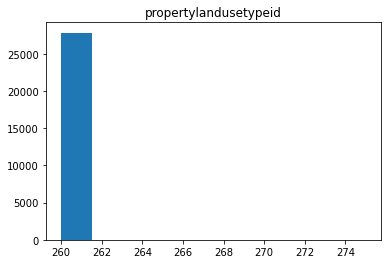

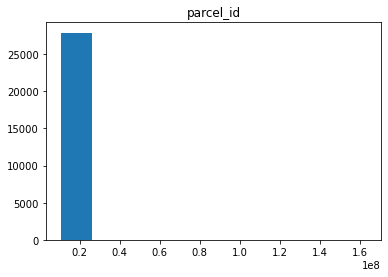

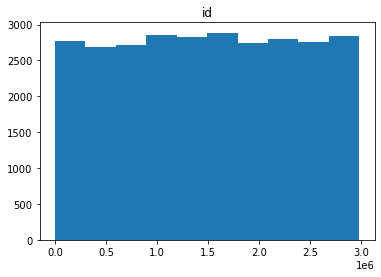

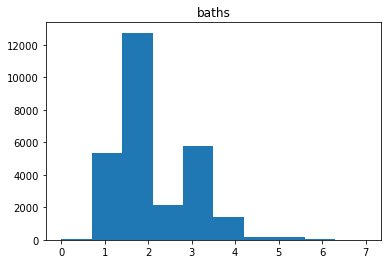

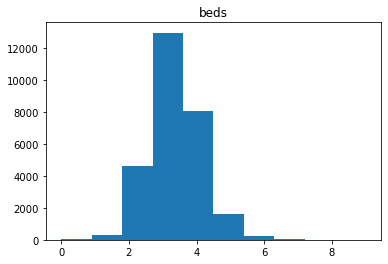

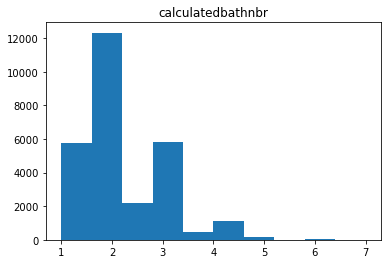

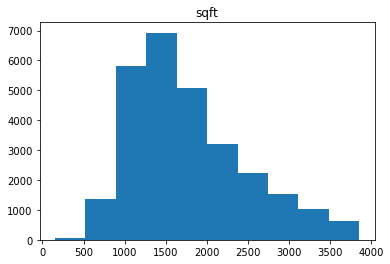

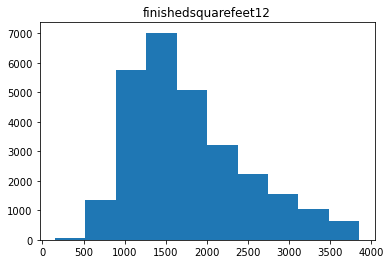

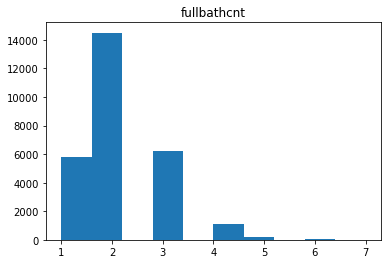

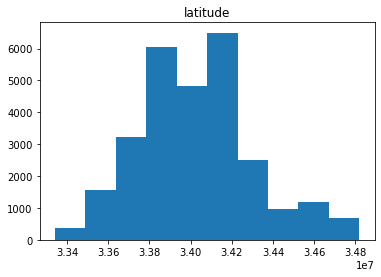

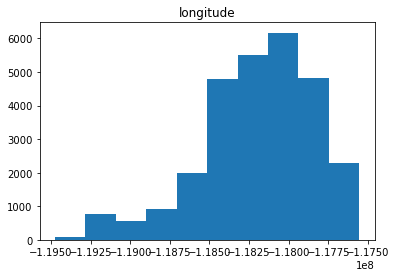

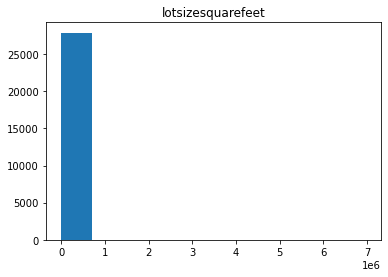

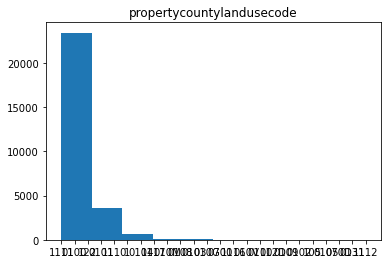

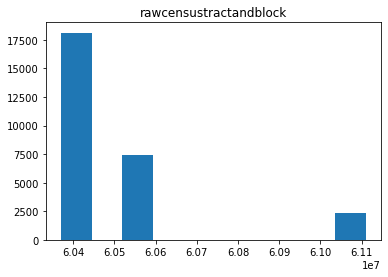

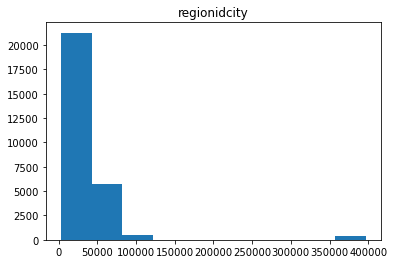

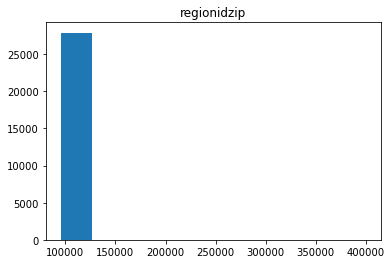

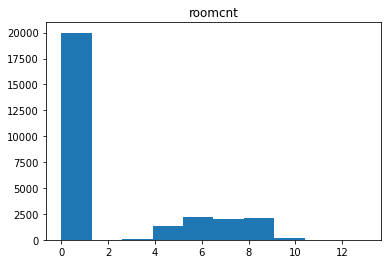

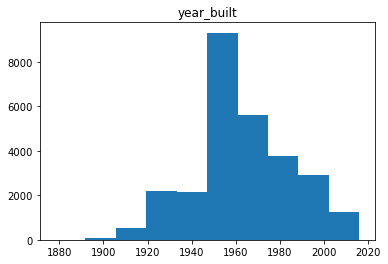

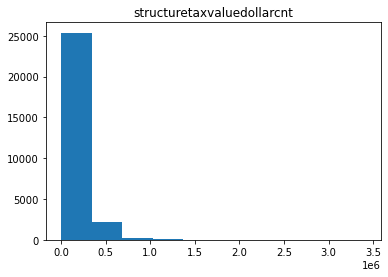

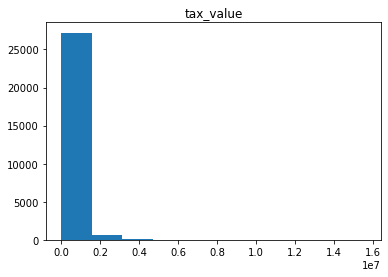

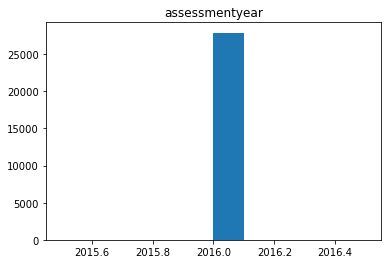

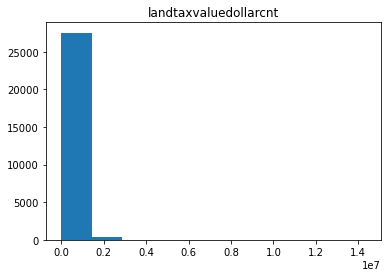

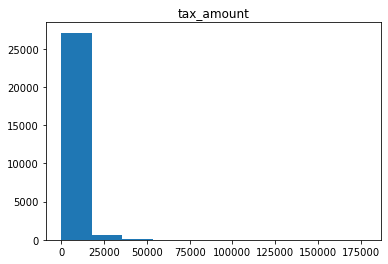

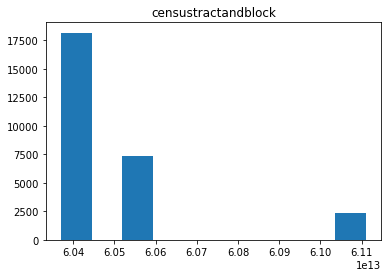

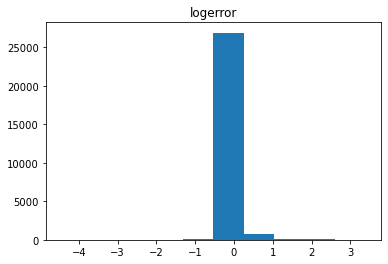

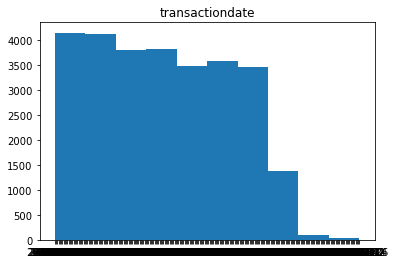

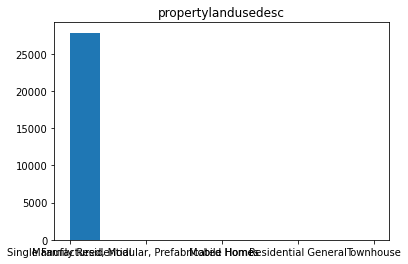

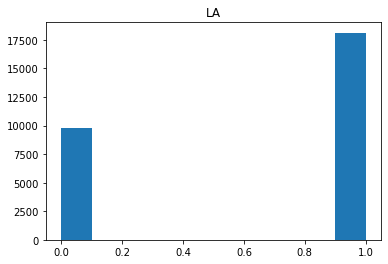

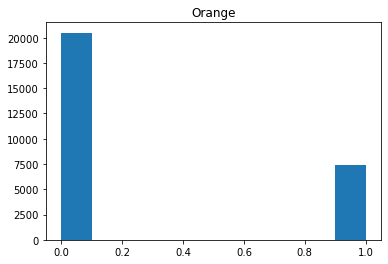

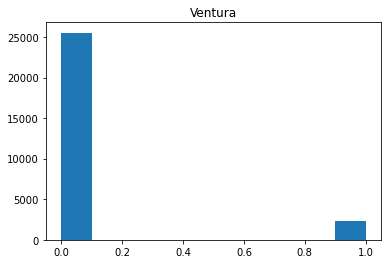

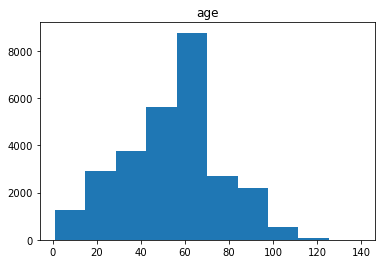

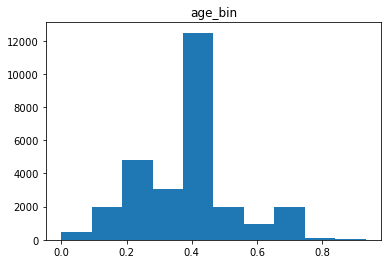

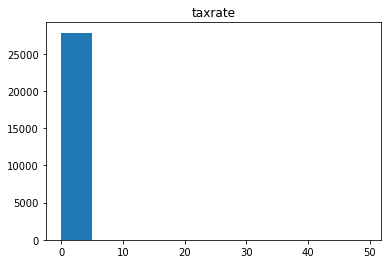

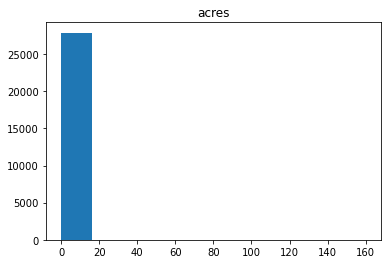

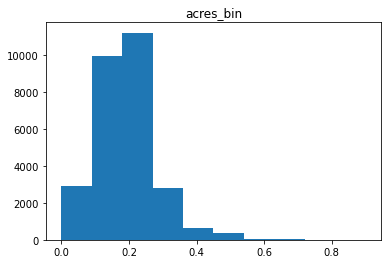

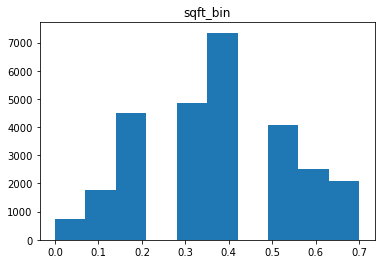

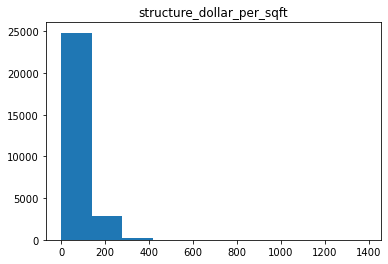

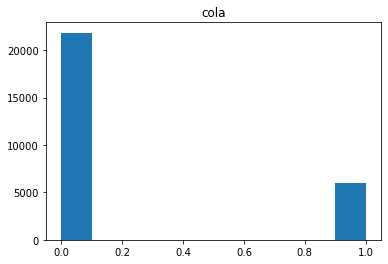

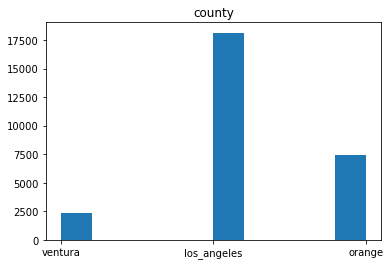

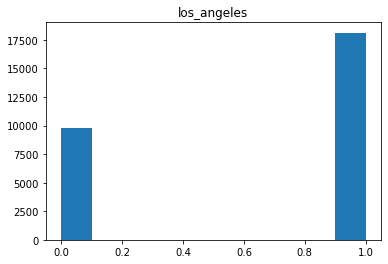

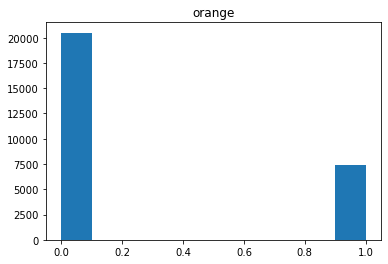

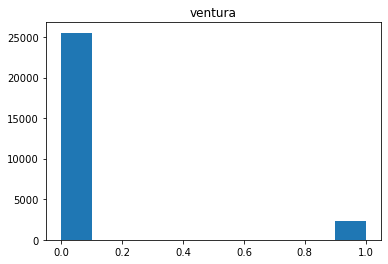

In [21]:
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

<AxesSubplot:title={'center':'Feautures Correlating with Log Error'}>

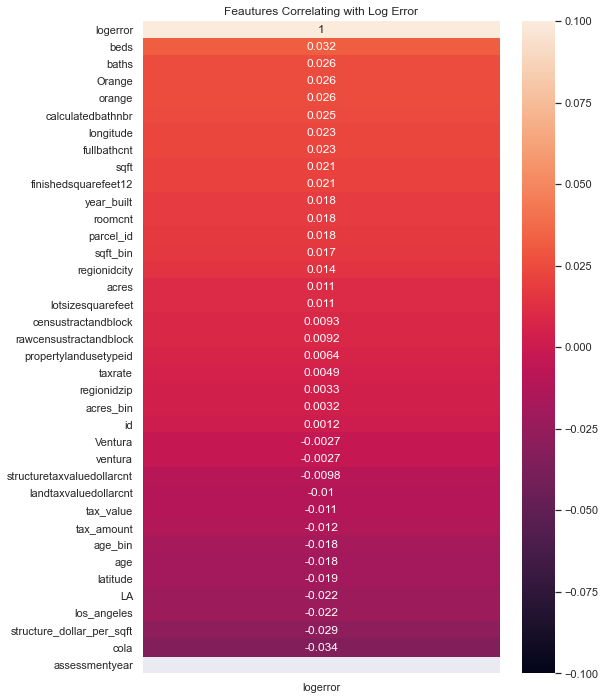

In [22]:
get_zillow_heatmap(train)

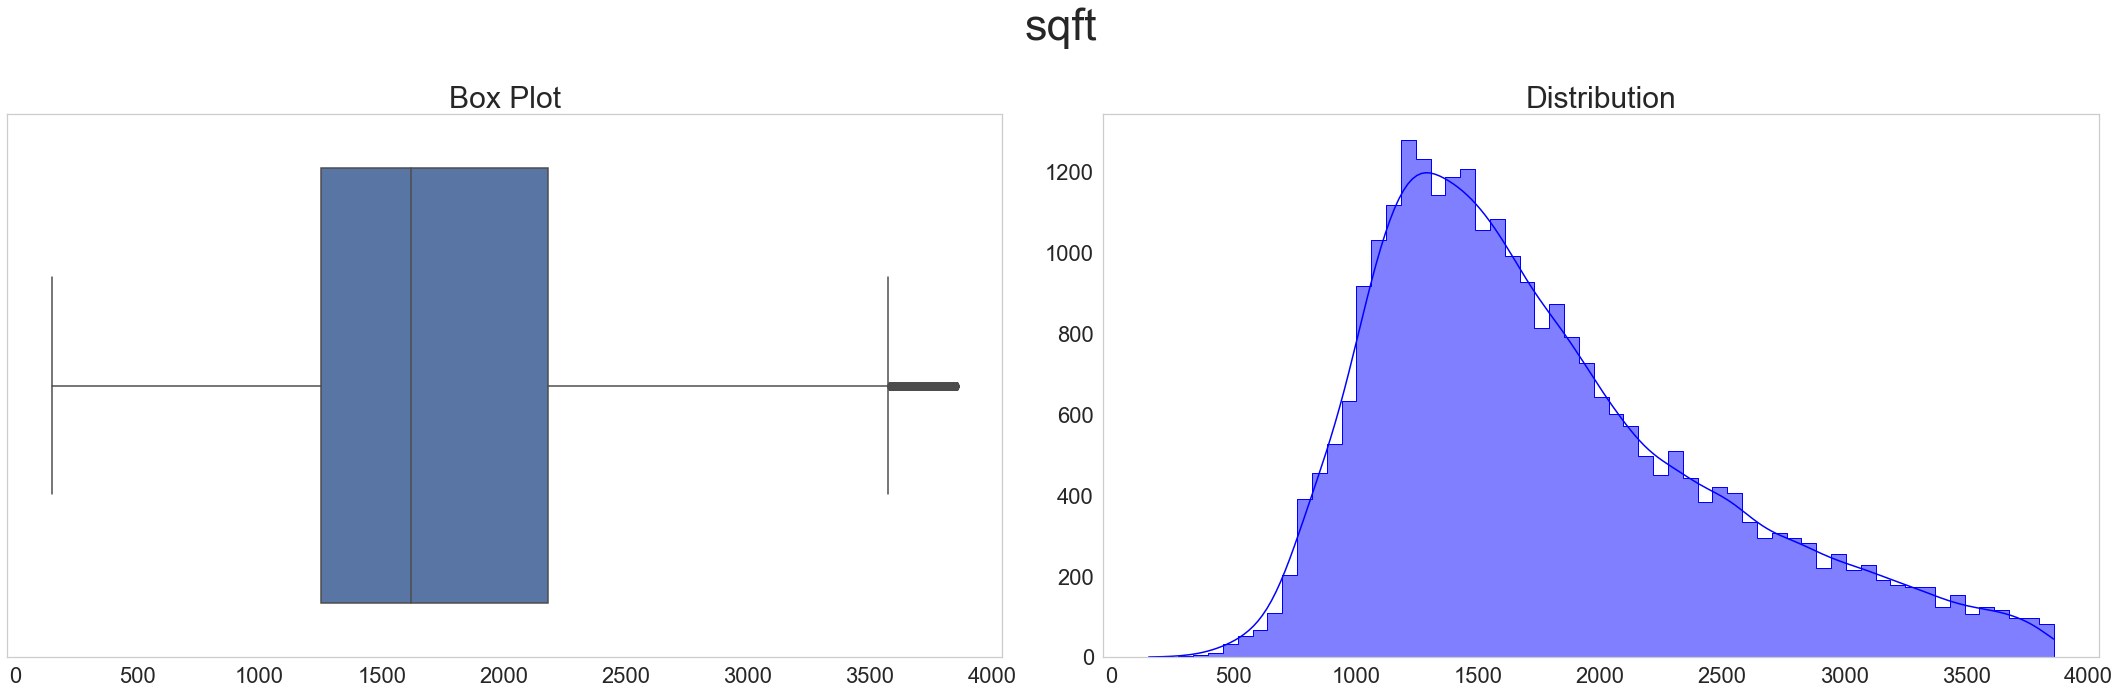

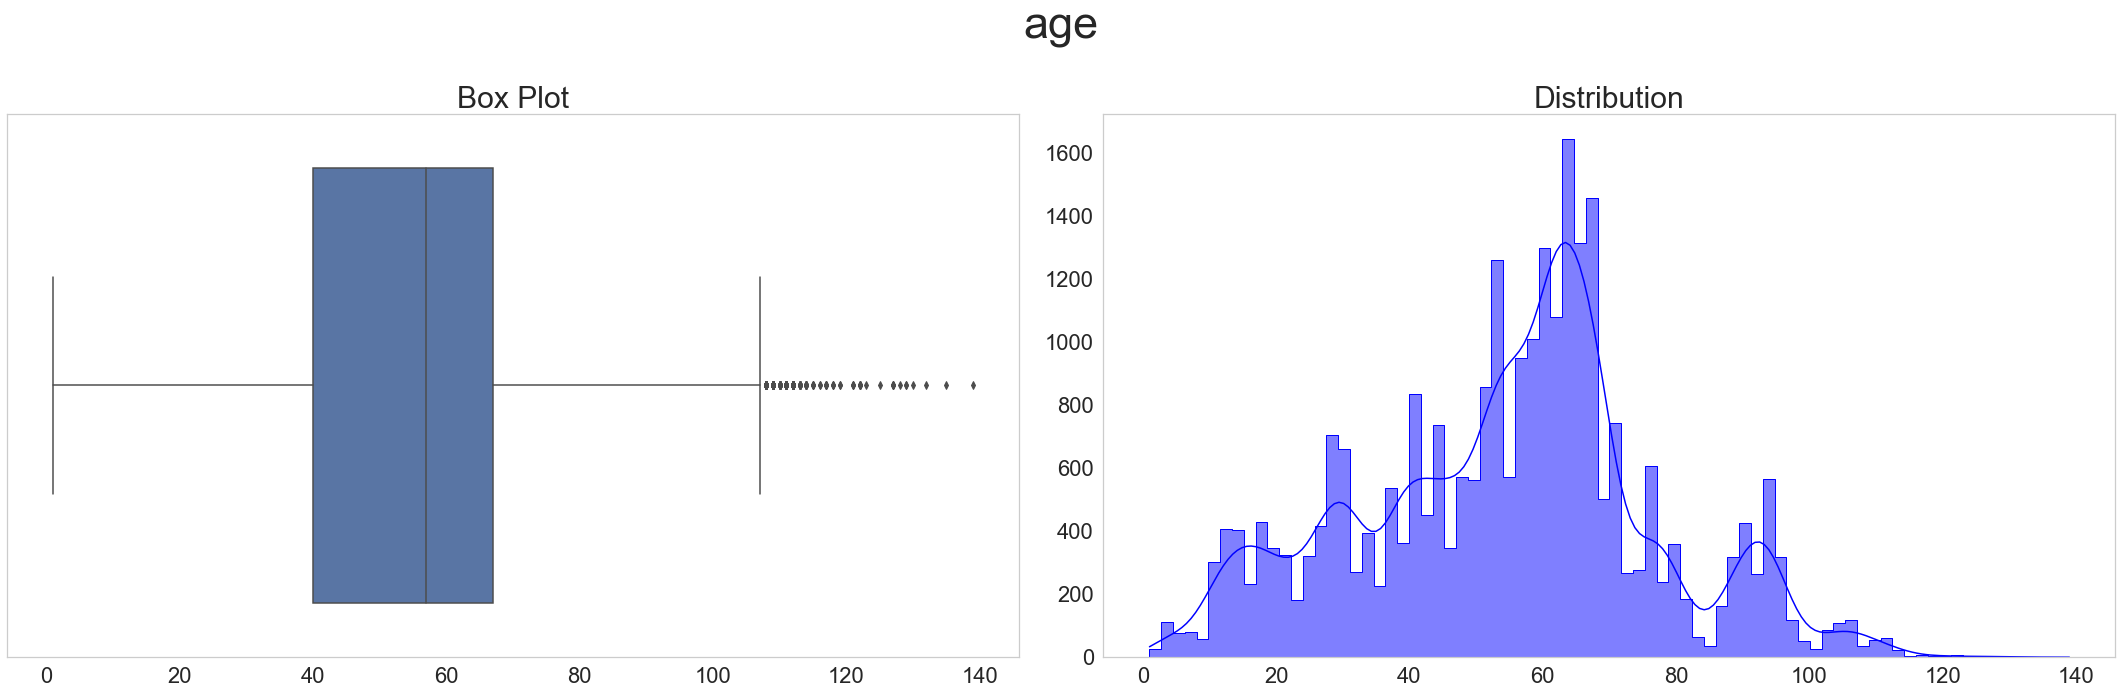

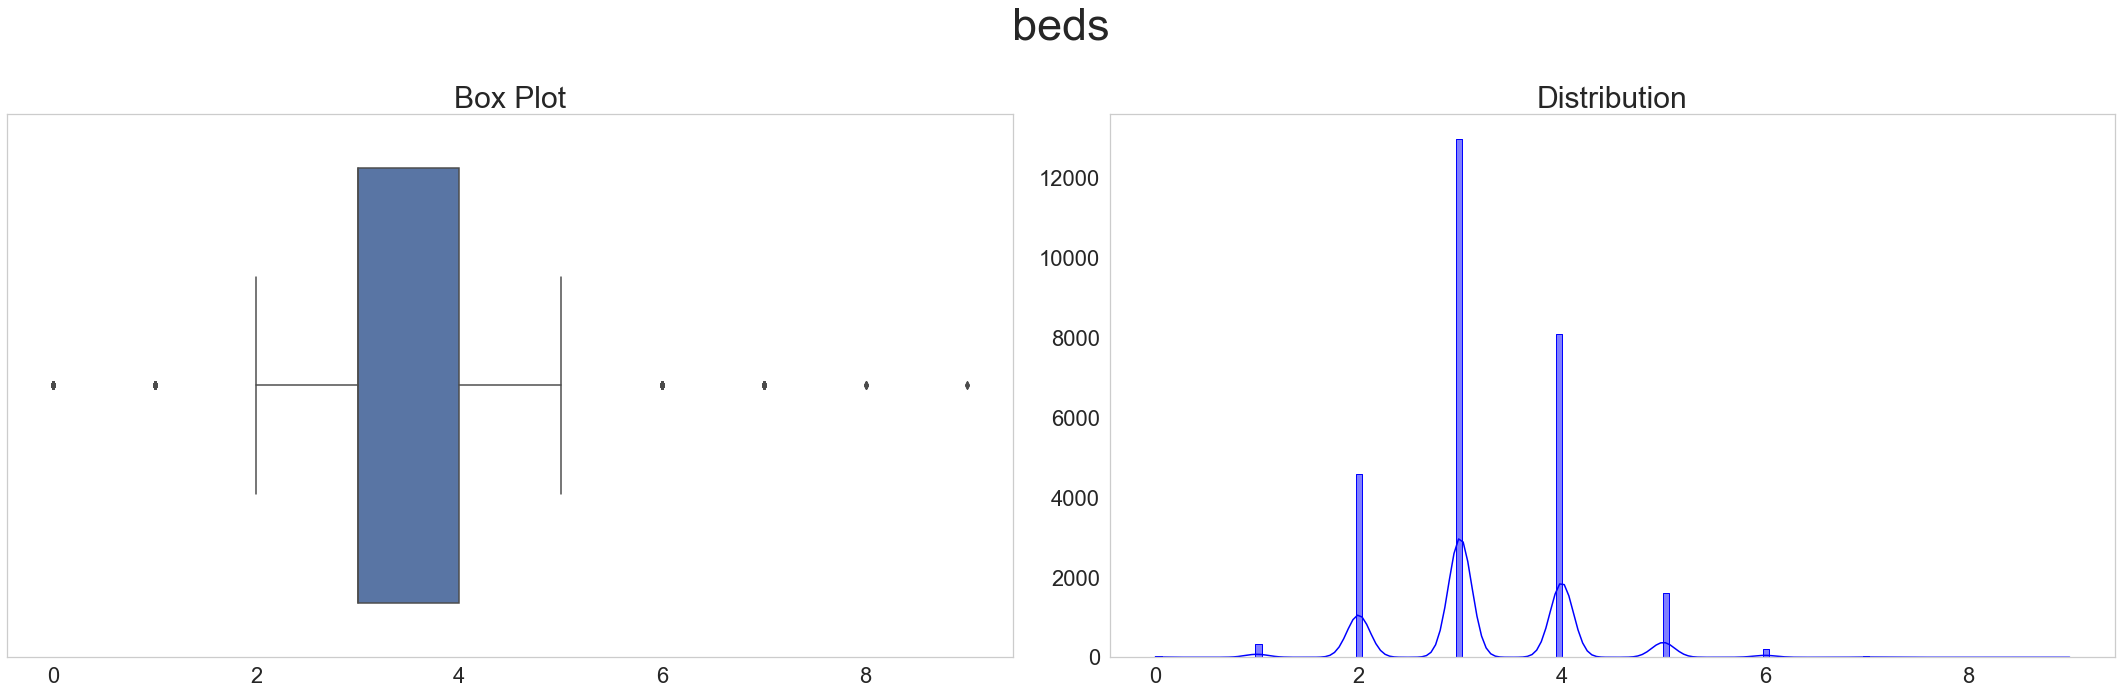

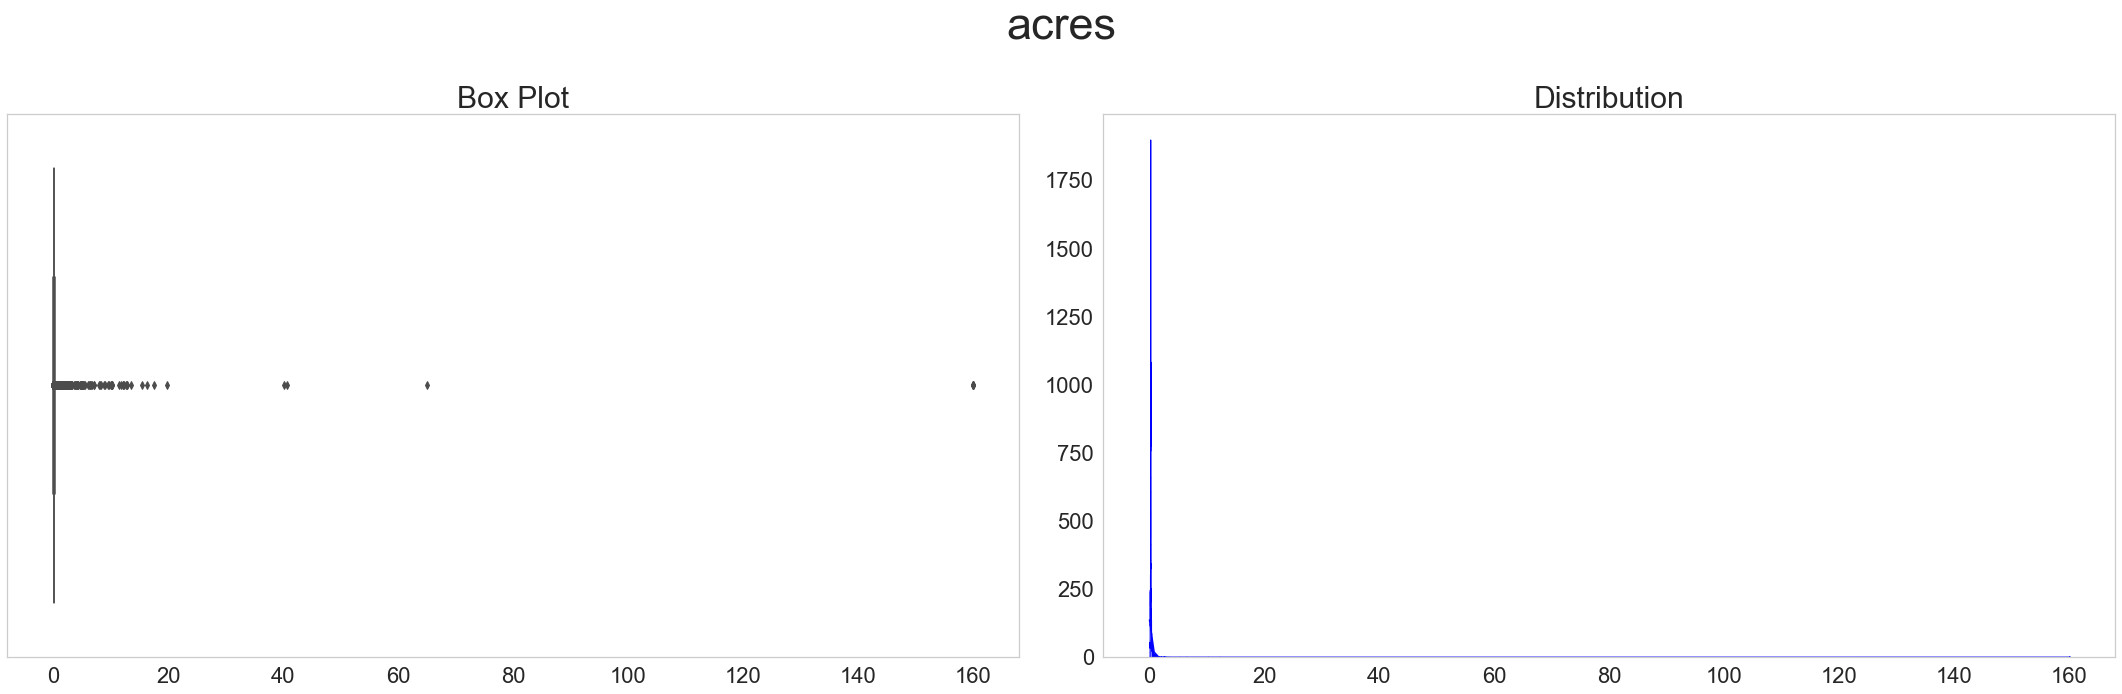

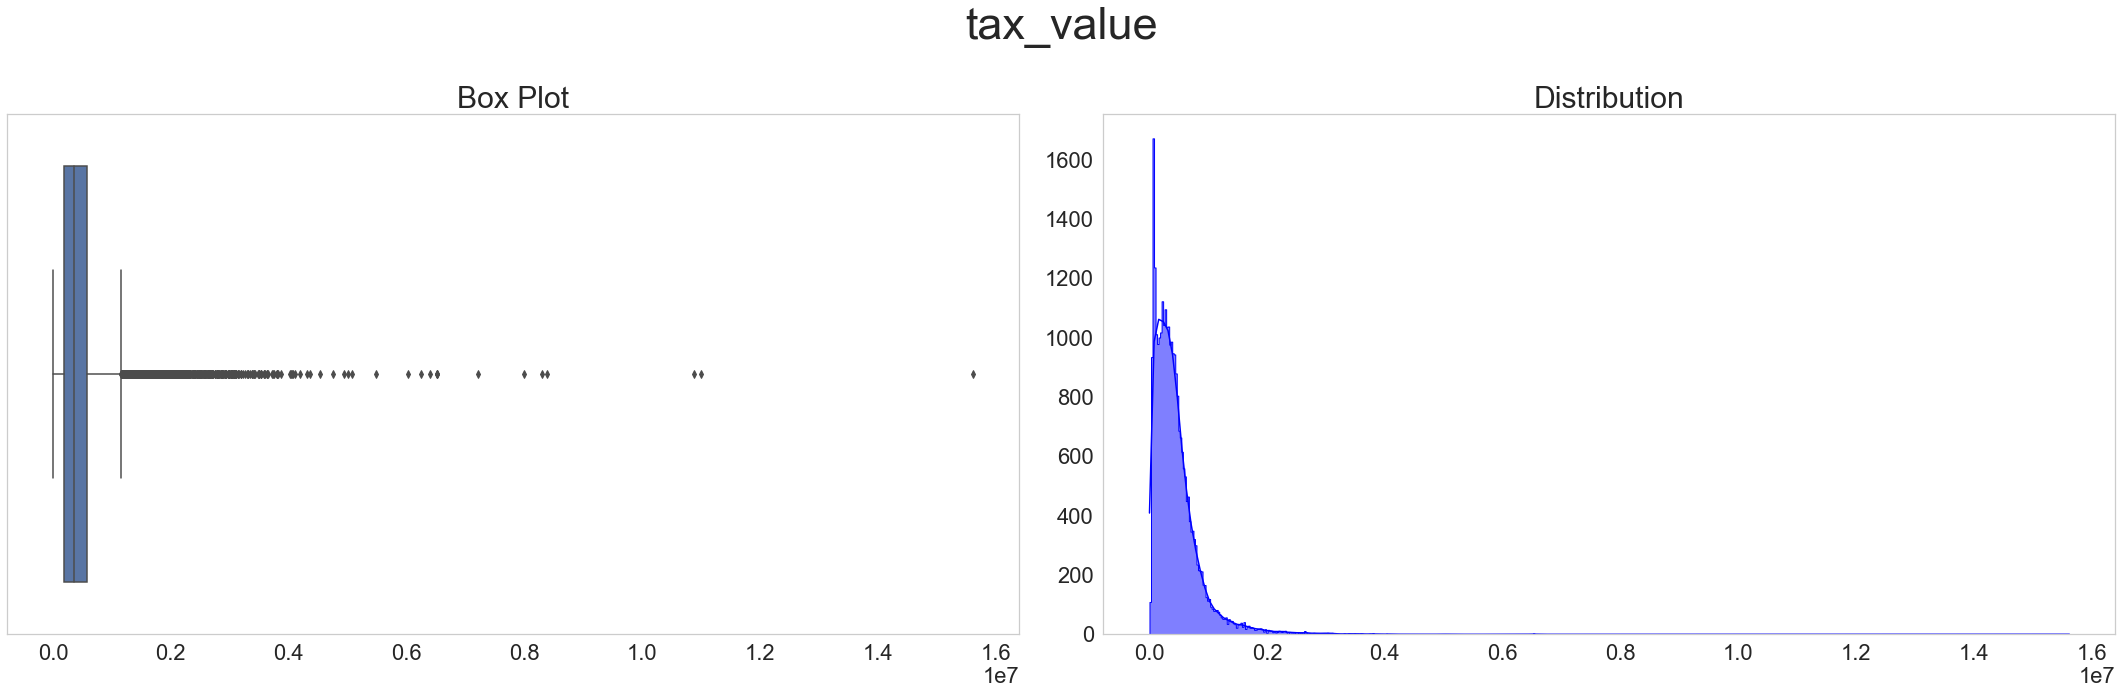

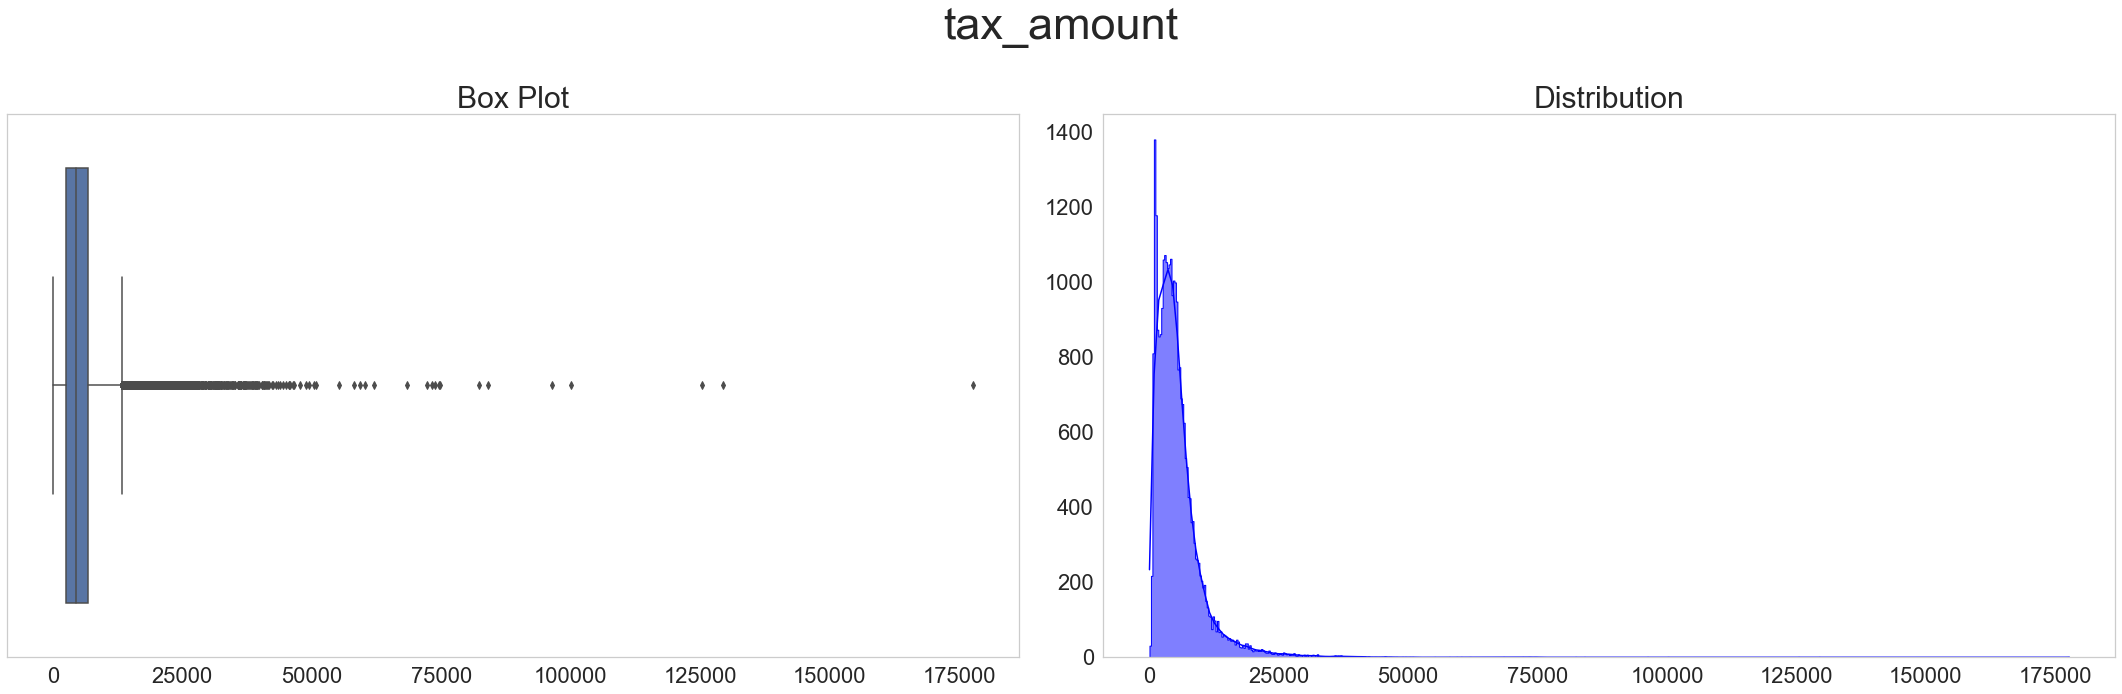

In [23]:
univariate_study = ['sqft','age','beds','acres','tax_value','tax_amount']

for i in univariate_study:
    explore_univariate(train, i)

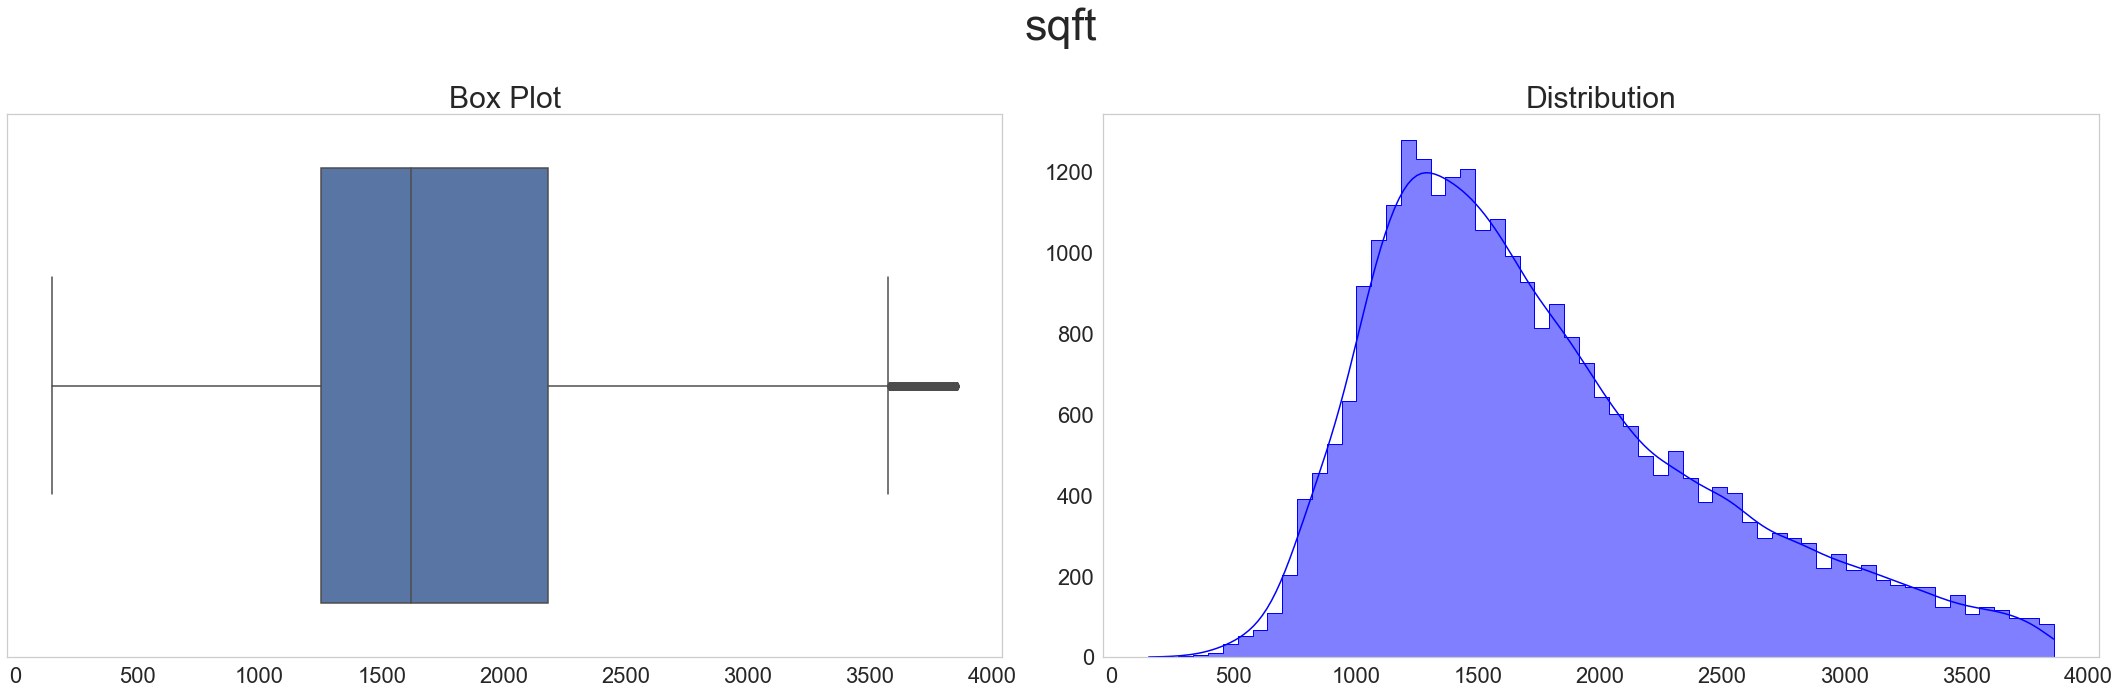

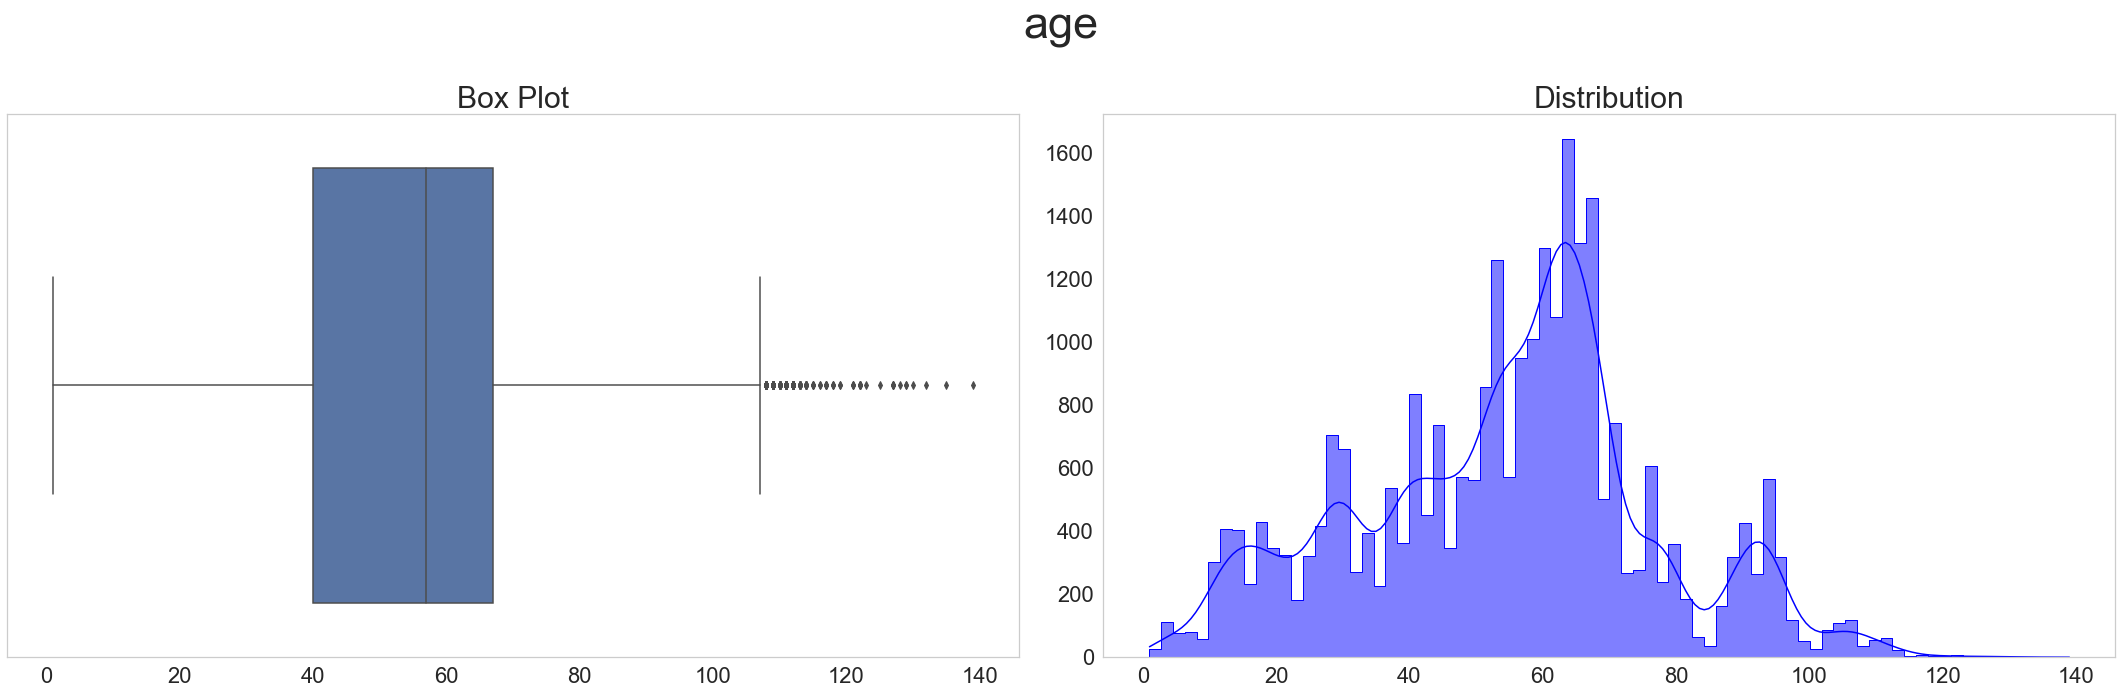

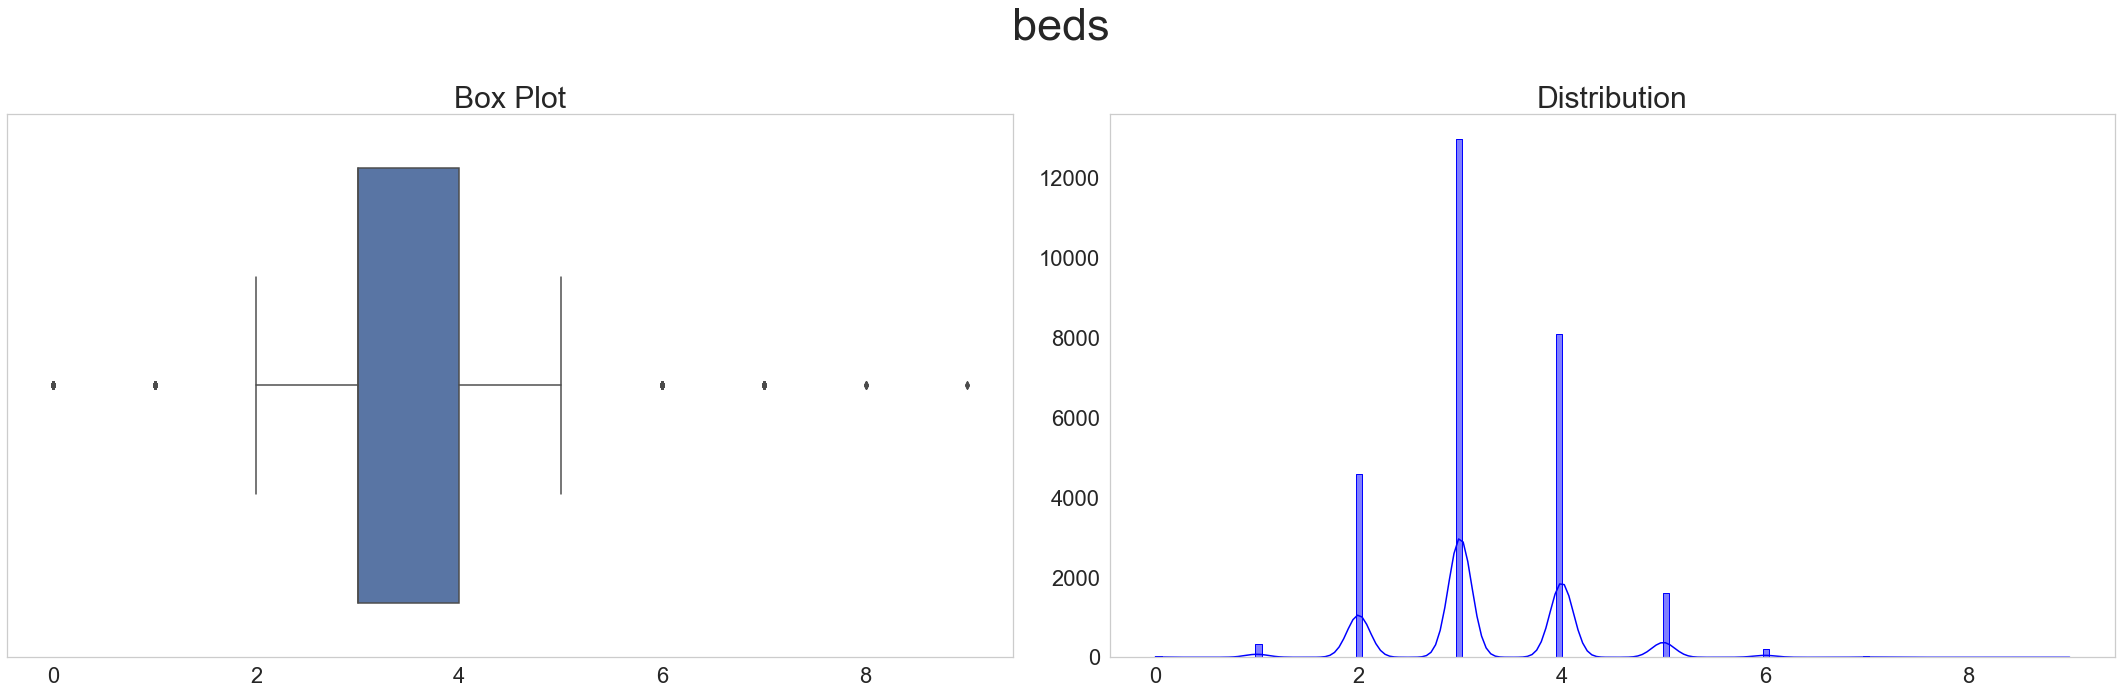

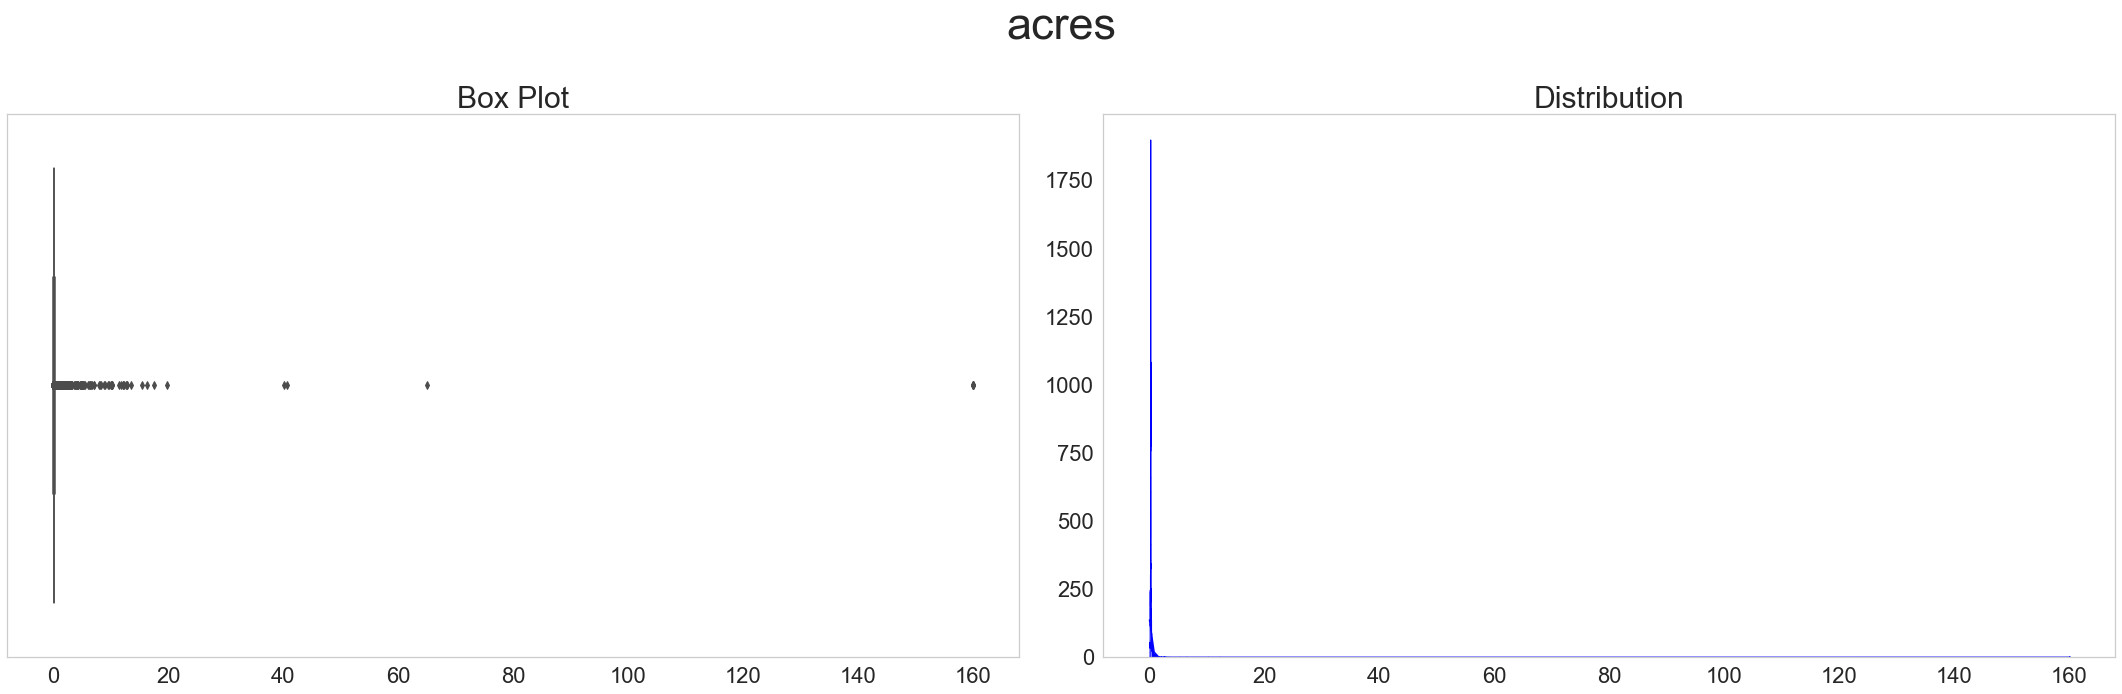

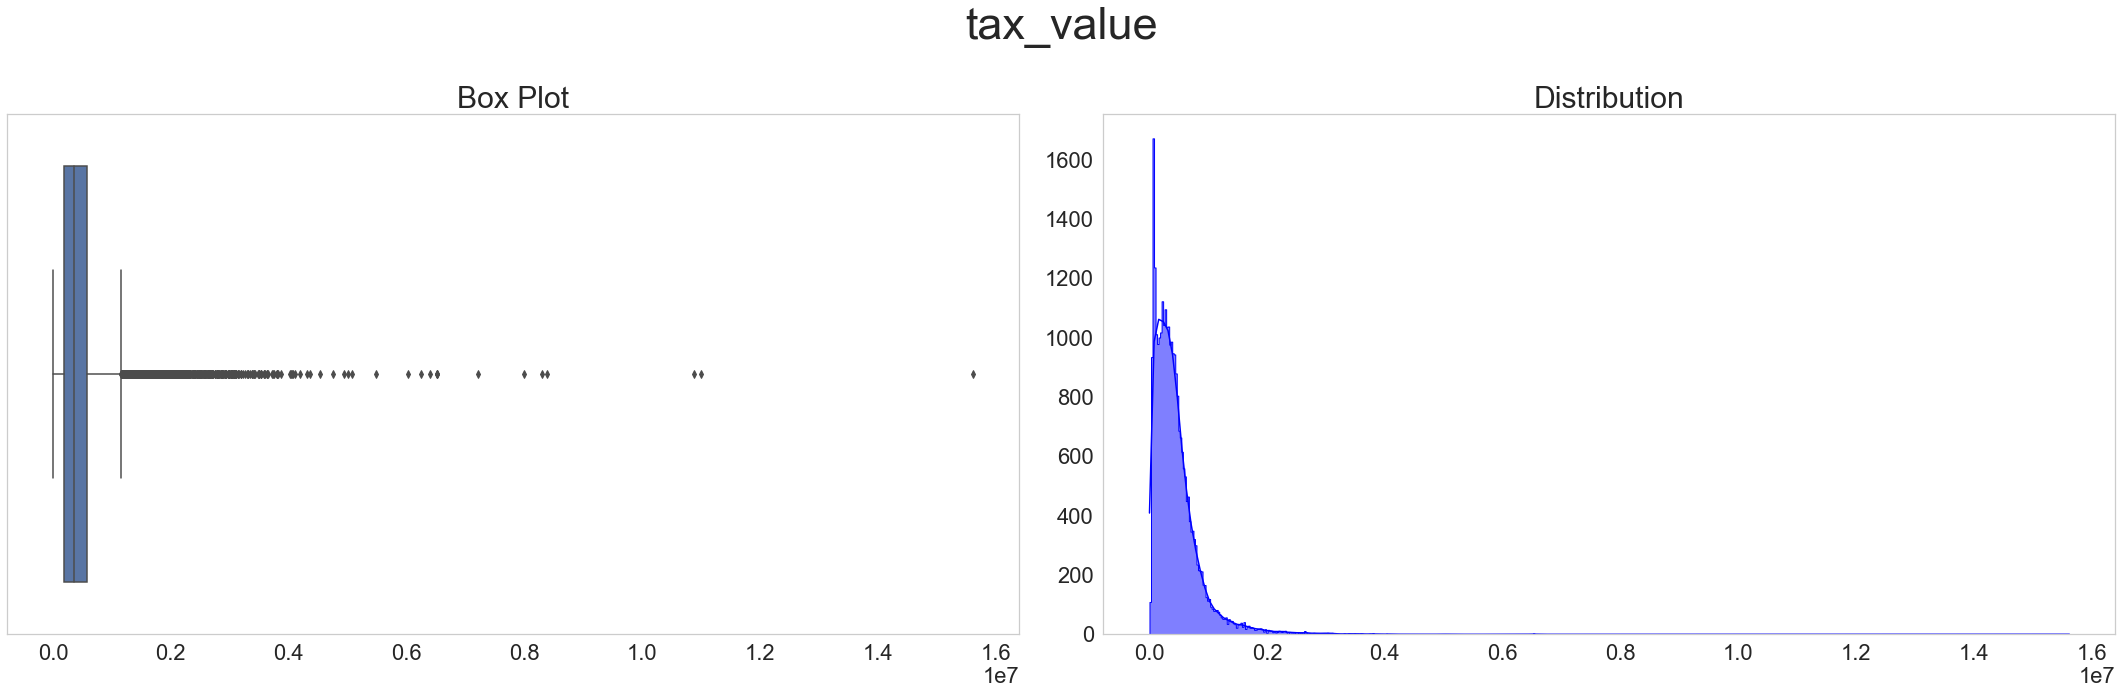

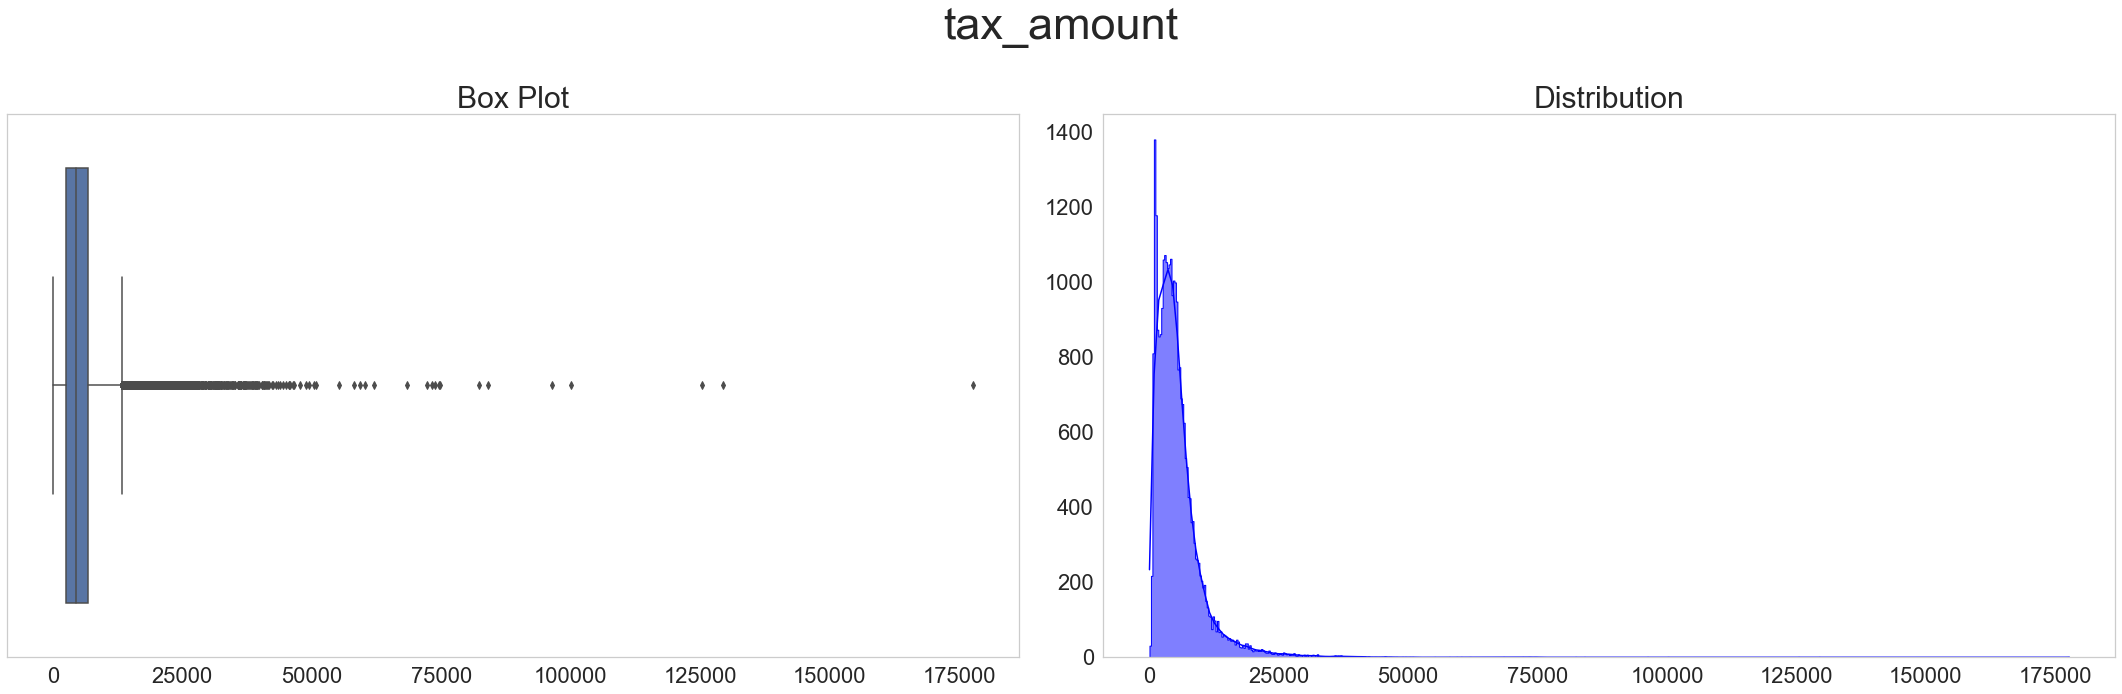

In [24]:
explore_univariate(train, 'sqft')


explore_univariate(train, 'age')


explore_univariate(train, 'beds')


explore_univariate(train, 'acres')

explore_univariate(train, 'tax_value')

explore_univariate(train, 'tax_amount')


# Bivariate Exploration

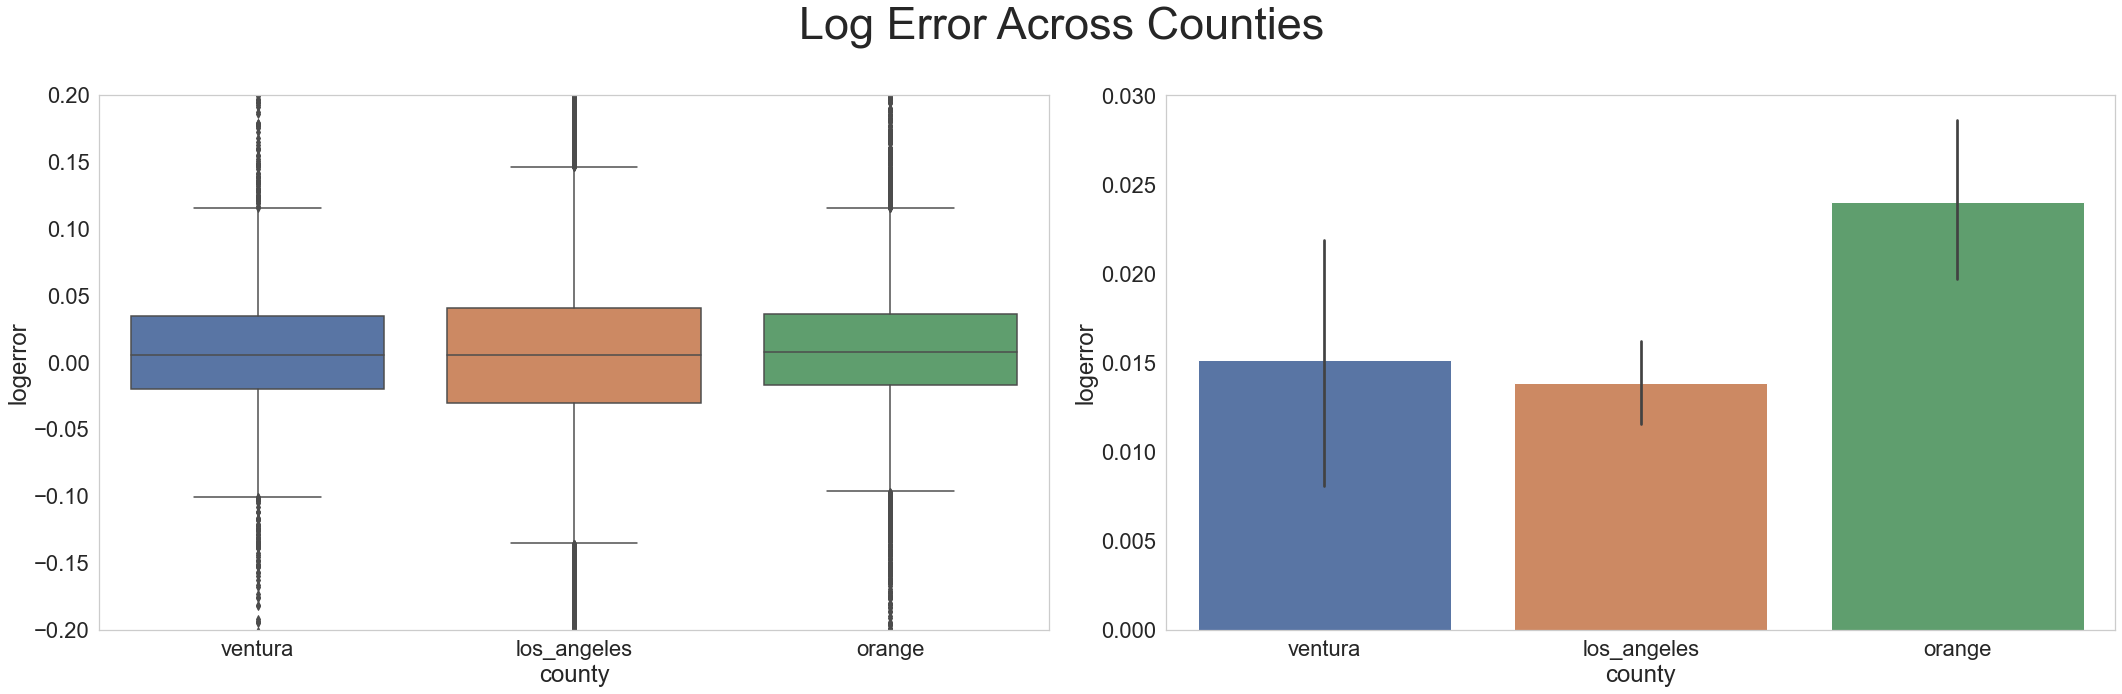

In [25]:
#logerror across counties (LA, Orange, and Ventura)

#set up figure size, font size, and turn off grid.
plt.figure(figsize=(30,10))
sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

#boxplot
plt.subplot(1, 2, 1)
sns.boxplot(train.county, train.logerror)
plt.ylim(-.2, .2)

#barplot
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='county',y='logerror')

#title
plt.suptitle('Log Error Across Counties', fontsize = 45)
plt.tight_layout()
plt.show()

In [26]:
null_hypothesis = "no difference in logerror between ventura county and the other counties"
alternative_hypothesis = "there is a difference in log error between ventura county and other counties"
a = 0.05 #a for alpha 

ventura_logerror=train[train.county=='ventura'].logerror
other_logerror = train[train.county!='ventura'].logerror
t, p = stats.ttest_ind(ventura_logerror, other_logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Fail to reject null hypothesis that: no difference in logerror between ventura county and the other counties There is not sufficient evidence to reject it.


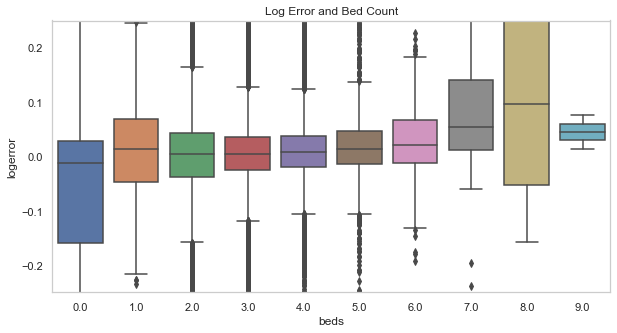

In [27]:
#Log error and number of beds
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.boxplot(train.beds, train.logerror)
plt.title('Log Error and Bed Count')
plt.ylim(-.25, .25)
plt.show()

In [28]:
null_hypothesis = "no difference in logerror between properties with 2 beds or less, or more beds"
alternative_hypothesis = "there is a difference in logerror between properties with 2 beds or less, or more beds"
a = 0.05 #a for alpha 

two_or_less_beds=train[train.beds<=2].logerror
more_than_two_beds = train[train.beds>2].logerror
t, p = stats.ttest_ind(two_or_less_beds, more_than_two_beds)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties with 2 beds or less, or more beds
There is evidence to suggest: there is a difference in logerror between properties with 2 beds or less, or more beds


Acres and LogError


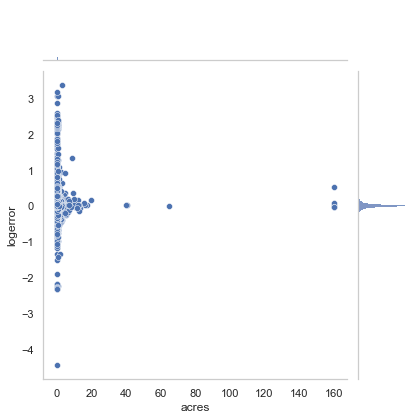

In [29]:
print('Acres and LogError')
sns.jointplot(x='acres', y='logerror', data=train)
plt.xlabel('Sqft')
plt.ylabel('Log Error')
plt.show()

In [30]:
null_hypothesis = "no difference in logerror between properties 2 acres or less, or with more acres"
alternative_hypothesis = "there is a difference in logerror between properties 2 acres or less, or with more acres"
a = 0.05 #a for alpha 

More_land=train[train.acres<=2].logerror
less_land = train[train.acres>2].logerror
t, p = stats.ttest_ind(More_land, less_land)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties 2 acres or less, or with more acres
There is evidence to suggest: there is a difference in logerror between properties 2 acres or less, or with more acres


In [31]:
null_hypothesis = "no difference in logerror between properties 1500 sqft or less, or with more square footage"
alternative_hypothesis = "there is a difference in logerror between properties 1500 sqft or less, or with more square footage"
a = 0.05 #a for alpha 

house=train[train.sqft<=1500].logerror
tiny_house = train[train.sqft>1500].logerror
t, p = stats.ttest_ind(house, tiny_house)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Fail to reject null hypothesis that: no difference in logerror between properties 1500 sqft or less, or with more square footage There is not sufficient evidence to reject it.


Sqft and LogError


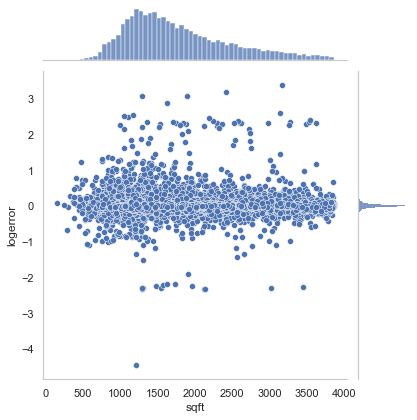

In [32]:
print('Sqft and LogError')
sns.jointplot(x='sqft', y='logerror', data=train)
plt.xlabel('Sqft')
plt.ylabel('Log Error')
plt.show()

# Multivariate Exploration

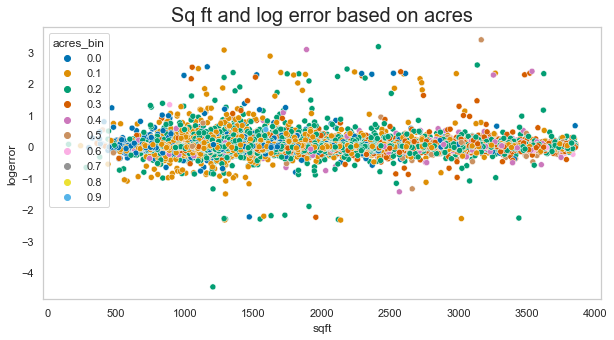

In [33]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='sqft',y='logerror',data=train,hue='acres_bin', palette='colorblind')
plt.title('Sq ft and log error based on acres', fontsize = 20)
plt.show()

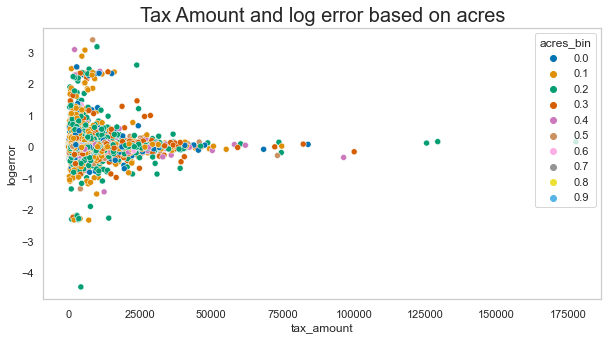

In [34]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='tax_amount',y='logerror',data=train,hue='acres_bin', palette='colorblind')
plt.title('Tax Amount and log error based on acres', fontsize = 20)
plt.show()

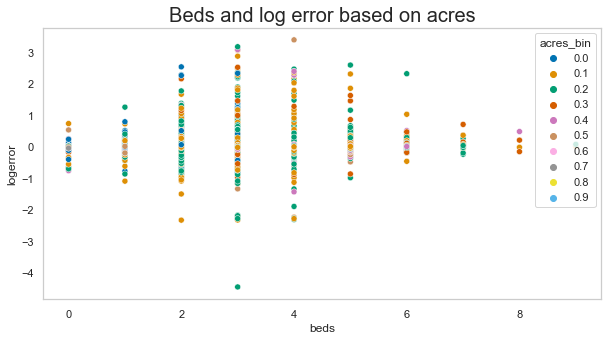

In [35]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='beds',y='logerror',data=train,hue='acres_bin', palette='colorblind')
plt.title('Beds and log error based on acres', fontsize = 20)
plt.show()

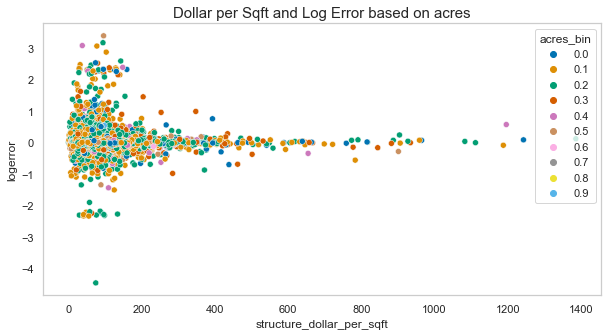

In [36]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='acres_bin', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on acres', fontsize=15)
plt.show()

Clusters based on acres and square footage


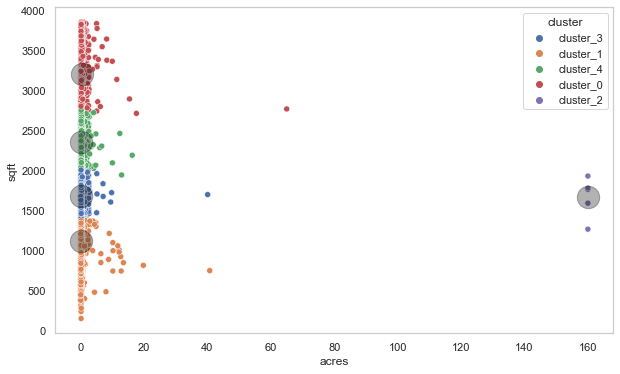

In [37]:
X = train[['acres', 'sqft']]
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 5)
create_scatter_plot('acres','sqft',train,kmeans, X_scaled, scaler)
print('Clusters based on acres and square footage')

In [53]:
X_features = train[['sqft', 'age', 'structure_dollar_per_sqft']]
X_features.columns

Index(['sqft', 'age', 'structure_dollar_per_sqft'], dtype='object')

In [59]:
X = X_train_scaled[['sqft', 'age', 'structure_dollar_per_sqft']]
# define the thing
kmeans = KMeans(n_clusters=4)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

X_train_scaled['cluster'] = kmeans.predict(X)
X_train_scaled.sample(5)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features.columns)

In [60]:
 # run several k-means, increment k with each iteration, and record the SSE:
kmeans_kwargs = {
             "init": "random",
              "n_init": 10,
              "max_iter": 300,
              "random_state":123,
    }
   
    # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)

In [61]:
from kneed import DataGenerator, KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

4

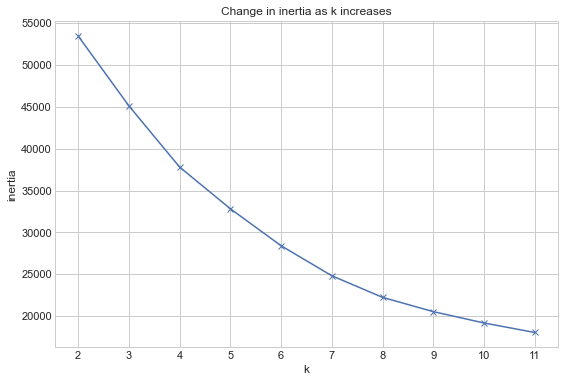

In [62]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

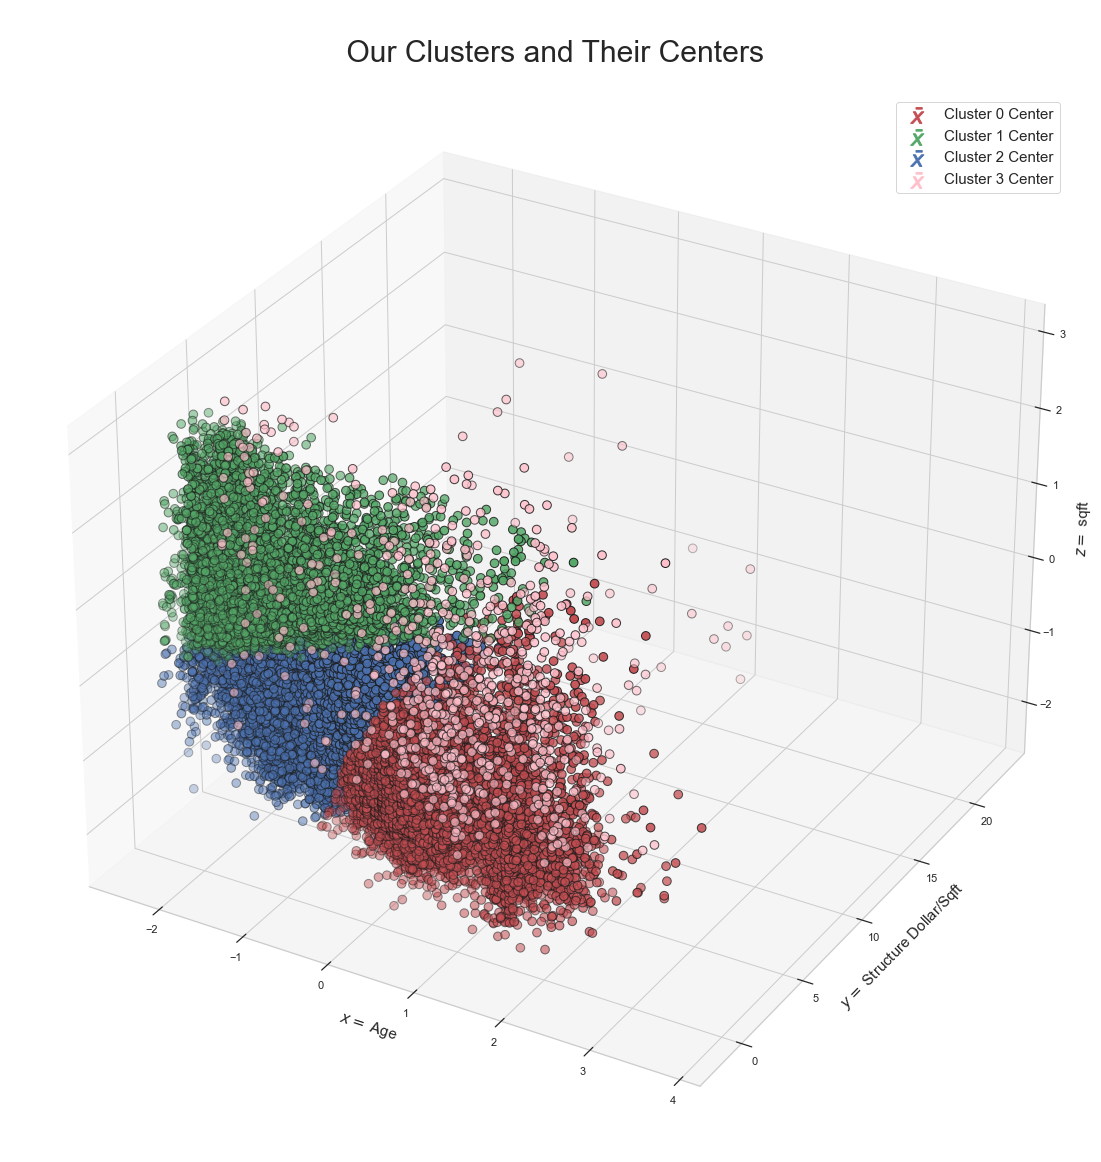

In [65]:
#%matplotlib osx
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# set x for each cluster
x0 = X_train_scaled[X_train_scaled['cluster'] == 0]['age']
x1 = X_train_scaled[X_train_scaled['cluster'] == 1]['age']
x2 = X_train_scaled[X_train_scaled['cluster'] == 2]['age']
x3 = X_train_scaled[X_train_scaled['cluster'] == 3]['age']



# set y for each cluster
y0 = X_train_scaled[X_train_scaled['cluster'] == 0]['structure_dollar_per_sqft']
y1 = X_train_scaled[X_train_scaled['cluster'] == 1]['structure_dollar_per_sqft']
y2 = X_train_scaled[X_train_scaled['cluster'] == 2]['structure_dollar_per_sqft']
y3 = X_train_scaled[X_train_scaled['cluster'] == 3]['structure_dollar_per_sqft']


# set z for each cluster
z0 = X_train_scaled[X_train_scaled['cluster'] == 0]['sqft']
z1 = X_train_scaled[X_train_scaled['cluster'] == 1]['sqft']
z2 = X_train_scaled[X_train_scaled['cluster'] == 2]['sqft']
z3 = X_train_scaled[X_train_scaled['cluster'] == 3]['sqft']


#centroids
zero_center = centroids[centroids.index == 0]
one_center = centroids[centroids.index == 1]
two_center = centroids[centroids.index == 2]
three_center = centroids[centroids.index == 3]
four_center = centroids[centroids.index == 4]

# plot cluster 0 with center
ax.scatter(x0, y0, z0, s=75, c='r', edgecolor='k', marker='o')
ax.scatter(zero_center.age, zero_center.structure_dollar_per_sqft, zero_center.sqft, s=250, c='r', marker='$\\bar{x}$', label='Cluster 0 Center')
# plot cluster 1 with center
ax.scatter(x1, y1, z1, s=75, c='g', edgecolor='k', marker='o')
ax.scatter(one_center.age, one_center.structure_dollar_per_sqft, one_center.sqft, s=250, c='g', marker='$\\bar{x}$', label='Cluster 1 Center')
# plot cluster 2 with center
ax.scatter(x2, y2, z2, s=75, c='b', edgecolor='k', marker='o')
ax.scatter(two_center.age, two_center.structure_dollar_per_sqft, two_center.sqft, s=250, c='b', marker='$\\bar{x}$', label='Cluster 2 Center')
#plot cluster 3 with center
ax.scatter(x3, y3, z3, s=75, c='pink', edgecolor='k', marker='o')
ax.scatter(three_center.age, three_center.structure_dollar_per_sqft, three_center.sqft, s=250, c='pink', marker='$\\bar{x}$', label='Cluster 3 Center')


# set labels and title
ax.set_xlabel('\n$x =$ Age', fontsize=15)
ax.set_ylabel('\n$y =$ Structure Dollar/Sqft', fontsize=15)
ax.set_zlabel('\n$z =$ sqft', fontsize=15)
plt.title('\n Our Clusters and Their Centers', fontsize=30)
plt.legend(bbox_to_anchor=(0.975,0.975), fontsize=15)
plt.show()

In [68]:
X_features_2 = train[['tax_amount', 'sqft', 'structure_dollar_per_sqft']]
X = X_train_scaled[['tax_amount', 'sqft', 'structure_dollar_per_sqft']]

# define the thing
kmeans = KMeans(n_clusters=3)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

X_train_scaled['cluster_tax'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features_2.columns)

In [69]:
# run several k-means, increment k with each iteration, and record the SSE:
kmeans_kwargs = {
             "init": "random",
              "n_init": 10,
              "max_iter": 300,
              "random_state":123,
    }
   
    # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)

In [70]:
from kneed import DataGenerator, KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

3

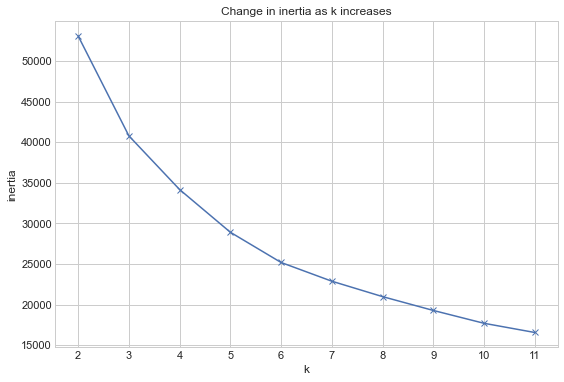

In [71]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

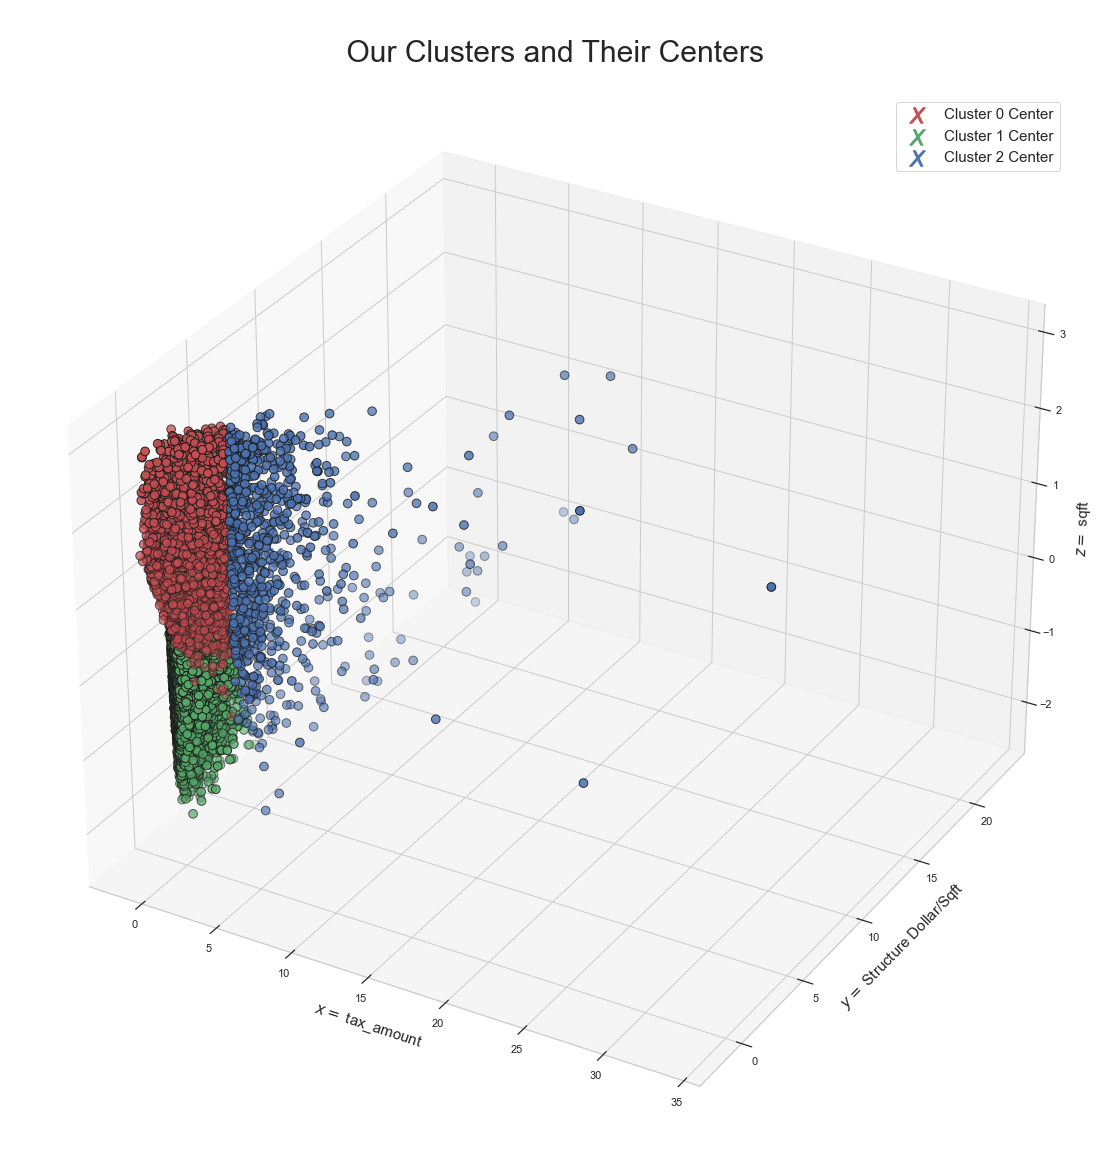

In [72]:
#%matplotlib osx
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# set x for each cluster
x0 = X_train_scaled[X_train_scaled['cluster_tax'] == 0]['tax_amount']
x1 = X_train_scaled[X_train_scaled['cluster_tax'] == 1]['tax_amount']
x2 = X_train_scaled[X_train_scaled['cluster_tax'] == 2]['tax_amount']




# set y for each cluster
y0 = X_train_scaled[X_train_scaled['cluster_tax'] == 0]['structure_dollar_per_sqft']
y1 = X_train_scaled[X_train_scaled['cluster_tax'] == 1]['structure_dollar_per_sqft']
y2 = X_train_scaled[X_train_scaled['cluster_tax'] == 2]['structure_dollar_per_sqft']



# set z for each cluster
z0 = X_train_scaled[X_train_scaled['cluster_tax'] == 0]['sqft']
z1 = X_train_scaled[X_train_scaled['cluster_tax'] == 1]['sqft']
z2 = X_train_scaled[X_train_scaled['cluster_tax'] == 2]['sqft']



zero_center = centroids[centroids.index == 0]
one_center = centroids[centroids.index == 1]
two_center = centroids[centroids.index == 2]


# plot cluster 0 with center
ax.scatter(x0, y0, z0, s=75, c='r', edgecolor='k', marker='o')
ax.scatter(zero_center.tax_amount, zero_center.structure_dollar_per_sqft, zero_center.sqft, s=250, c='r', marker='$X$', label='Cluster 0 Center')
ax.scatter(x1, y1, z1, s=75, c='g', edgecolor='k', marker='o')
ax.scatter(one_center.tax_amount, one_center.structure_dollar_per_sqft, one_center.sqft, s=250, c='g', marker='$X$', label='Cluster 1 Center')
# plot cluster 2 with center
ax.scatter(x2, y2, z2, s=75, c='b', edgecolor='k', marker='o')
ax.scatter(two_center.tax_amount, two_center.structure_dollar_per_sqft, two_center.sqft, s=250, c='b', marker='$X$', label='Cluster 2 Center')
#
# set labels and title
ax.set_xlabel('\n$x =$ tax_amount', fontsize=15)
ax.set_ylabel('\n$y =$ Structure Dollar/Sqft', fontsize=15)
ax.set_zlabel('\n$z =$ sqft', fontsize=15)
plt.title('\n Our Clusters and Their Centers', fontsize=30)
plt.legend(bbox_to_anchor=(0.975,0.975), fontsize=15)
plt.show()


In [ ]:
#SELECT K BEST
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [ ]:
f_feature

In [ ]:
X_train_scaled = X_train_scaled.drop(columns='cluster')

In [ ]:
X_train_scaled

In [ ]:
number_of_features_list=np.arange(1,40)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

In [ ]:
cols = list(X_train_scaled.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 13)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

In [ ]:

from sklearn.metrics import mean_squared_error, r2_score
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#logerror mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

#logerror_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

#RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('----------------------------------')

#RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('----------------------------------')
r2_baseline = r2_score(y_validate.logerror, y_validate.logerror_pred_mean)
print(f'The r^2 score for baseline is {round(r2_baseline,3)}')

In [ ]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

In [ ]:
selected_features = ['baths', 'beds', 'sqft', 
       'structuretaxvaluedollarcnt', 'tax_value', 'tax_amount',]
       
#Our first model: LinearRegression
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

#predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm = r2_score(y_validate.logerror, y_validate.logerror_pred_lm)
print(f'The r^2 value for linear regression is {round(r2_score_lm,3)}')

In [ ]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)

In [ ]:
selected_features = ['baths', 'beds', 'sqft', 
       'structuretaxvaluedollarcnt', 'tax_value', 'tax_amount',]
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

#predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for OLS using LassoLars:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lars = r2_score(y_validate.logerror, y_validate.logerror_pred_lars)
print(f'The r^2 value for LassoLars regression is {round(r2_score_lars,3)}')

In [ ]:
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha = 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lars)}, ignore_index=True)

In [ ]:
#TweedieRegressor
#create model object
glm = TweedieRegressor(power = 0,alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

#predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for OLS using TweedieRegressor:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_glm = r2_score(y_validate.logerror, y_validate.logerror_pred_glm)
print(f'The r^2 value for TweedieRegressor regression is {round(r2_score_glm,3)}')

In [ ]:
metric_df = metric_df.append(
    {
    'model': 'GLM Model power 0',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_glm)}, ignore_index=True)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=2)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled, and X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled[selected_features])
X_test_degree2 = pf.transform(X_test_scaled[selected_features])

#linear regresson with 2 degrees
lm2 = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm2.fit(X_train_degree2,y_train.logerror)

#predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

#predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for OLS using Polynomial Regression (2 degrees):\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm2 = r2_score(y_validate.logerror, y_validate.logerror_pred_lm2)
print(f'The r^2 value for Polynomial Regression (2 degrees) is {round(r2_score_lm2,3)}')

In [ ]:
metric_df = metric_df.append(
    {
    'model': 'Cubic Model',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm2)}, ignore_index=True)

In [ ]:
metric_df

In [ ]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="black")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm-y_validate.logerror, 
            alpha=1, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars-y_validate.logerror, 
            alpha=1, color="green", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm-y_validate.logerror, 
            alpha=1, color="orange", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2-y_validate.logerror, 
            alpha=.5, color="dodgerblue", s=100, edgecolors='black', label="Model 2nd degree Polynomial")
plt.legend()

plt.xlabel("Actual Logerror of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Logerror of Property Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})

In [ ]:
#looks like 3rd degree polynomial did the best, let's visualize that
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.logerror, y=y_validate.logerror_pred_lm, 
            scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel("Actual Log Error of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Log Error of Property W/ Linear Regression Model", fontdict={'fontsize':15})
plt.title("Linear Regression Model", fontdict={'fontsize': 20})

plt.show()

In [ ]:
#turning it into a dataframe
y_test = pd.DataFrame(y_test)

# predicting on our test model
y_test['logerror_pred_lm'] = lm.predict(X_test_scaled[selected_features])

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm)**(1/2)
print('             ')
print('             Our Test Model')
print('----------------------------------')
print('----------------------------------')
print("RMSE for OLS Linear Regression Model \nOut-of-Sample Performance: ", rmse_test)
r2_test_score_lm = r2_score(y_test.logerror, y_test.logerror_pred_lm)
print(f'OLS Linear Regression has an R^2 value of {round(r2_test_score_lm,3)}')

In [ ]:
# plot prediction and actual distributions
plt.figure(figsize=(40, 15))
# set bins using min, mean, and max of actual values
bins1 = np.linspace(-2.33172653205, 0.0142533962575622464, 25)
bins2 = np.linspace(0.0142533962575622465, 2.52399218129, 25)
bins = bins1 + bins2
sns.histplot(y_test.logerror, bins=bins, label='Actual')
# set bins using min, mean, and max of values in predictions
bins1 = np.linspace(-0.03555942199743989, 0.0155444512995399324, 25)
bins2 = np.linspace(0.0155444512995399325, 0.0890508308087443, 25)
bins = bins1 + bins2
sns.histplot(y_test.logerror_pred_lm, bins=bins, color='pink', alpha=1, label='Predicted')
# set display settings
plt.xlim(-2.6, 2.6)
plt.xticks(fontsize=25)
plt.xlabel('log_error',fontsize=25)
plt.yscale('log')
plt.yticks(ticks=[1, 10, 100, 1000, 10000], labels=[1, 10, 100, 1000, 10000], fontsize=25)
plt.ylabel('')
plt.title('\nDistribution of Predicted and Actual Log Error\n', fontsize=30)
plt.legend(fontsize=30)
# show plot
plt.show()